## 1. Problem Definition

This project is designed to address the critical business need of detecting potential frauds in healthcare systems. It does this by developing a binary classification model that categorizes claims as either fraudulent or legitimate. The overarching goal is to reduce financial losses for insurance companies, thereby enhancing the effectiveness of fraud management within healthcare systems.

To align the model's performance with our business objectives, I have selected the F1 score as the performance metric. This choice is strategic, as the F1 score balances the need for both precision (avoiding false positives to maintain customer satisfaction) and recall (ensuring a high detection rate of actual fraudulent claims). This metric effectively encapsulates the dual objective of maximizing fraud detection while minimizing the impact on genuine customers, directly correlating to the project's aim of efficient and accurate fraud identification in healthcare claims.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
import shap
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures,OneHotEncoder,MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV,KFold,train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix ,classification_report
from sklearn.utils.class_weight import compute_class_weight

## 2. Data Collection

In [2]:
# download 4 datasets from kaggle
# load the data
df_label = pd.read_csv(".\kaggle_data\Train-1542865627584.csv")
df_bene = pd.read_csv(".\kaggle_data\Train_Beneficiarydata-1542865627584.csv")
df_outp = pd.read_csv(".\kaggle_data\Train_Outpatientdata-1542865627584.csv")

## 3. EDA and Feature Engineering

In [3]:
# merge data
df_outp = pd.merge(df_outp,df_bene,on="BeneID",how="left")
df_outp = pd.merge(df_outp,df_label,on="Provider",how="left")
nrow = df_outp.shape[0]
ncol = df_outp.shape[1]

##### (1). Analysis of patterns and distributions of individual features

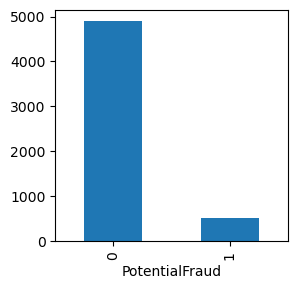

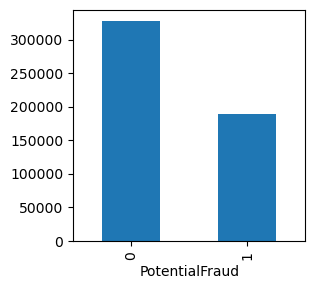

The dataset is imbalanced at both claim level and provider level. Therefore, it is essential to recalibrate its weighting during the model training process.


In [4]:
# The pattern of PotentialFraud
df_label["PotentialFraud"] = df_label["PotentialFraud"].apply(lambda x: 1 if x=="Yes" else 0)
df_outp["PotentialFraud"] = df_outp["PotentialFraud"].apply(lambda x: 1 if x=="Yes" else 0)

plt.figure(figsize=(3, 3))
df_label.groupby("PotentialFraud").count()["Provider"].plot(kind='bar')
plt.show()

plt.figure(figsize=(3, 3))
df_outp.groupby("PotentialFraud").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation 
print("The dataset is imbalanced at both claim level and provider level. Therefore, it is essential to recalibrate its weighting during the model training process.")

# Sample counts for each class
positive_cases = df_outp.groupby("PotentialFraud").count()["ClaimID"].iloc[1]
negative_cases = df_outp.groupby("PotentialFraud").count()["ClaimID"].iloc[0]

<Figure size 1000x300 with 0 Axes>

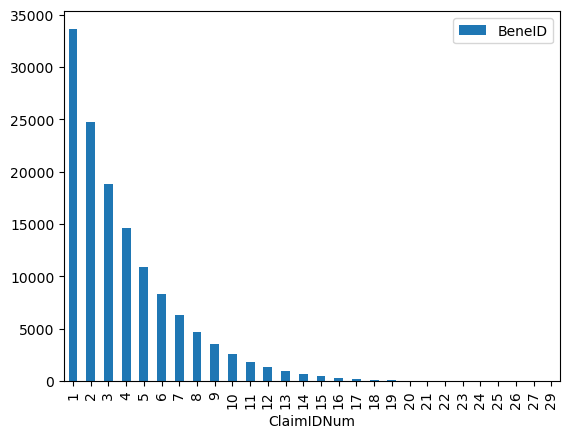

The mean of the number of claims for each BeneID:3.86
The median of the number of claims for each BeneID:3.00
As the number of claims per beneficiary increases, the total count of such beneficiaries decreases.


In [5]:
# The pattern of BeneID
plt.figure(figsize=(10, 3))
df_outp.groupby("BeneID").count()["ClaimID"].reset_index(name = "ClaimIDNum").groupby("ClaimIDNum").count().plot(kind="bar")
plt.show()

# The median and mean of the number of claims for each BeneID
MeanBeneID = df_outp.groupby("BeneID").count()["ClaimID"].mean()
MedianBeneID = df_outp.groupby("BeneID").count()["ClaimID"].median()

# Observation: 
print(f"The mean of the number of claims for each BeneID:{MeanBeneID:.2f}")
print(f"The median of the number of claims for each BeneID:{MedianBeneID:.2f}")
print("As the number of claims per beneficiary increases, the total count of such beneficiaries decreases.")

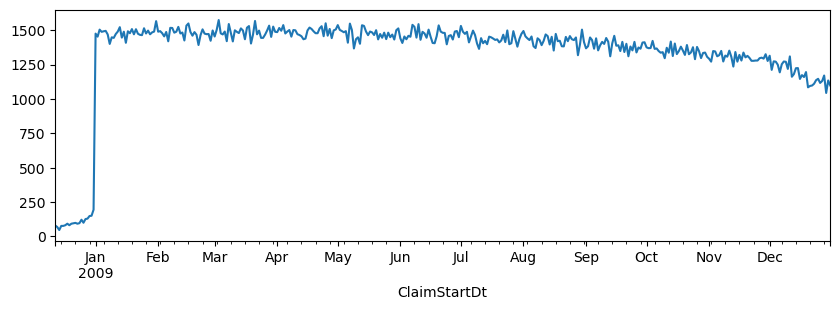

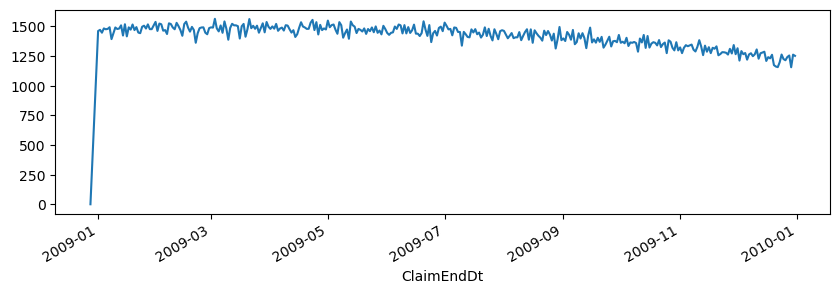

There was a slight decrease in the number of claims throughout 2009.


In [6]:
# convert the start date and end date of claims
df_outp["ClaimStartDt"] = pd.to_datetime(df_outp["ClaimStartDt"])
df_outp["ClaimEndDt"] = pd.to_datetime(df_outp["ClaimEndDt"])

# The pattern of ClaimStartDt
plt.figure(figsize=(10, 3))
df_outp.groupby("ClaimStartDt").count()["ClaimID"].plot(kind="line")
plt.show()

# The pattern of ClaimEndDt
plt.figure(figsize=(10, 3))
df_outp.groupby("ClaimEndDt").count()["ClaimID"].plot(kind="line")
plt.show()

# Observation: 
print("There was a slight decrease in the number of claims throughout 2009.")

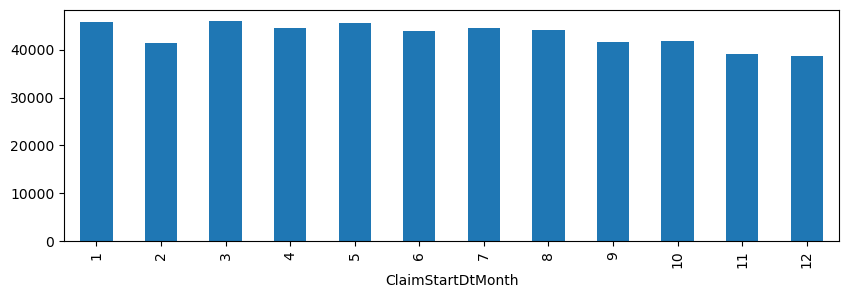

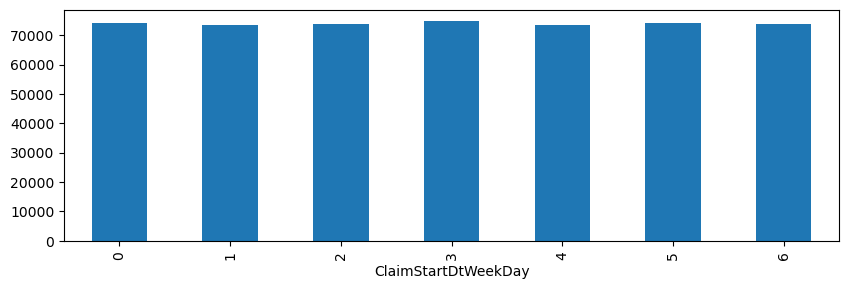

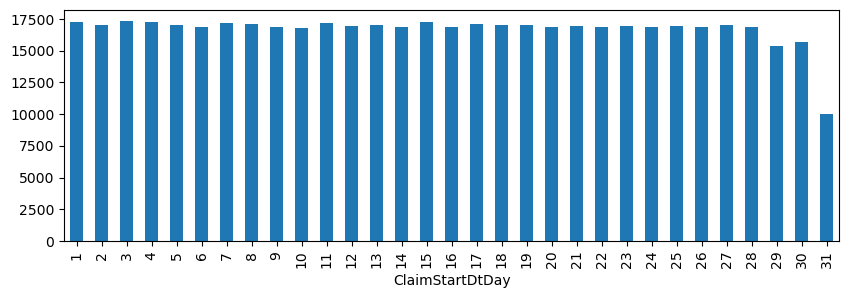

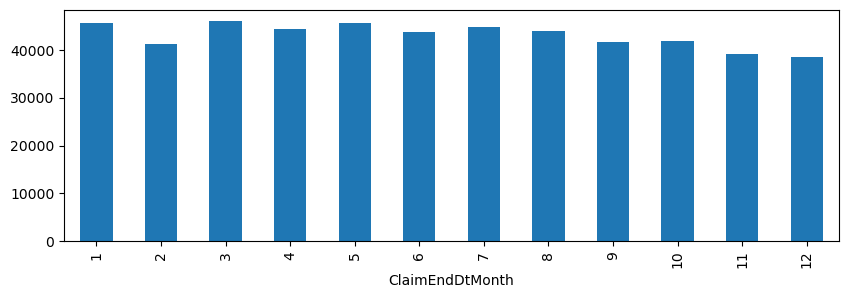

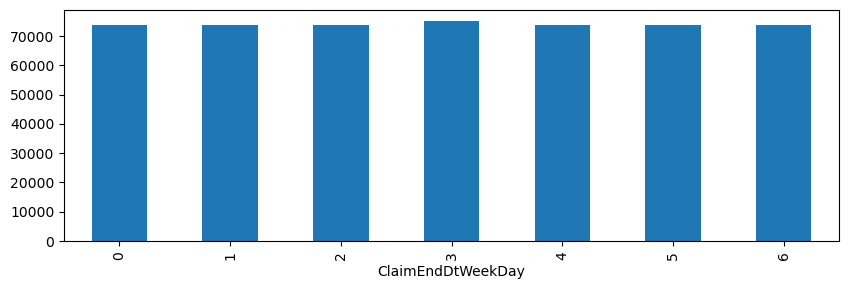

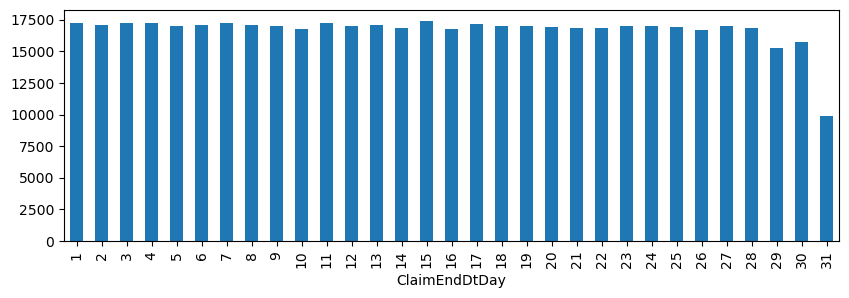

The number of claims demonstrates a monthly downward trend, and the smallest number of claims typically occurred at the end of the month.


In [7]:
# add new columns
df_outp["ClaimStartDtMonth"]  =  pd.to_datetime(df_outp["ClaimStartDt"]).dt.month
df_outp["ClaimStartDtWeekDay"]  =  pd.to_datetime(df_outp["ClaimStartDt"]).dt.weekday
df_outp["ClaimStartDtDay"]  =  pd.to_datetime(df_outp["ClaimStartDt"]).dt.day

df_outp["ClaimEndDtMonth"]  =  pd.to_datetime(df_outp["ClaimEndDt"]).dt.month
df_outp["ClaimEndDtWeekDay"]  =  pd.to_datetime(df_outp["ClaimEndDt"]).dt.weekday
df_outp["ClaimEndDtDay"]  =  pd.to_datetime(df_outp["ClaimEndDt"]).dt.day

# The pattern of ClaimStartDtMonth
plt.figure(figsize=(10, 3))
df_outp.groupby("ClaimStartDtMonth").count()["ClaimID"].plot(kind="bar")
plt.show()

# The pattern of ClaimStartDtWeekDay
plt.figure(figsize=(10, 3))
df_outp.groupby("ClaimStartDtWeekDay").count()["ClaimID"].plot(kind="bar")
plt.show()

# The pattern of ClaimStartDtDay
plt.figure(figsize=(10, 3))
df_outp.groupby("ClaimStartDtDay").count()["ClaimID"].plot(kind="bar")
plt.show()

# The pattern of ClaimEndDtMonth
plt.figure(figsize=(10, 3))
df_outp.groupby("ClaimEndDtMonth").count()["ClaimID"].plot(kind="bar")
plt.show()

# The pattern of ClaimEndDtWeekDay
plt.figure(figsize=(10, 3))
df_outp.groupby("ClaimEndDtWeekDay").count()["ClaimID"].plot(kind="bar")
plt.show()

# The pattern of ClaimEndDtDay
plt.figure(figsize=(10, 3))
df_outp.groupby("ClaimEndDtDay").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation:
print("The number of claims demonstrates a monthly downward trend, and the smallest number of claims typically occurred at the end of the month.")

<Figure size 600x300 with 0 Axes>

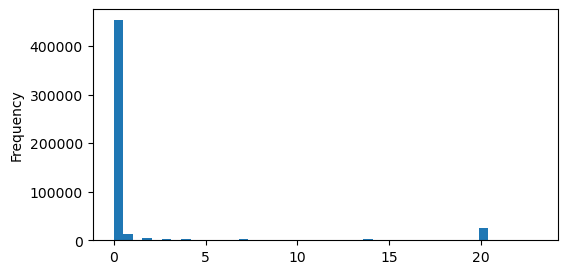

The median of the Claim Duration 0.00
The mean of the Claim Duration 1.42
Most claims have the same start date and end date.


In [8]:
# add a new column
plt.figure(figsize=(6, 3))
df_outp["ClaimDuration"] = df_outp["ClaimEndDt"] - df_outp["ClaimStartDt"]
df_outp["ClaimDuration"] = df_outp["ClaimDuration"].apply(lambda x:x.days)

# The distribution of ClaimDuration
plt.figure(figsize=(6, 3))
df_outp["ClaimDuration"].plot(kind="hist",bins= int(1 + 3.322 * np.log(nrow)))
plt.show()

# The median and mean of the ClaimDuration
MedianClaimDuration = df_outp["ClaimDuration"].median()
MeanClaimDuration = df_outp["ClaimDuration"].mean()

# Observation: 
print(f"The median of the Claim Duration {MedianClaimDuration:.2f}")
print(f"The mean of the Claim Duration {MeanClaimDuration:.2f}")
print(f"Most claims have the same start date and end date.")

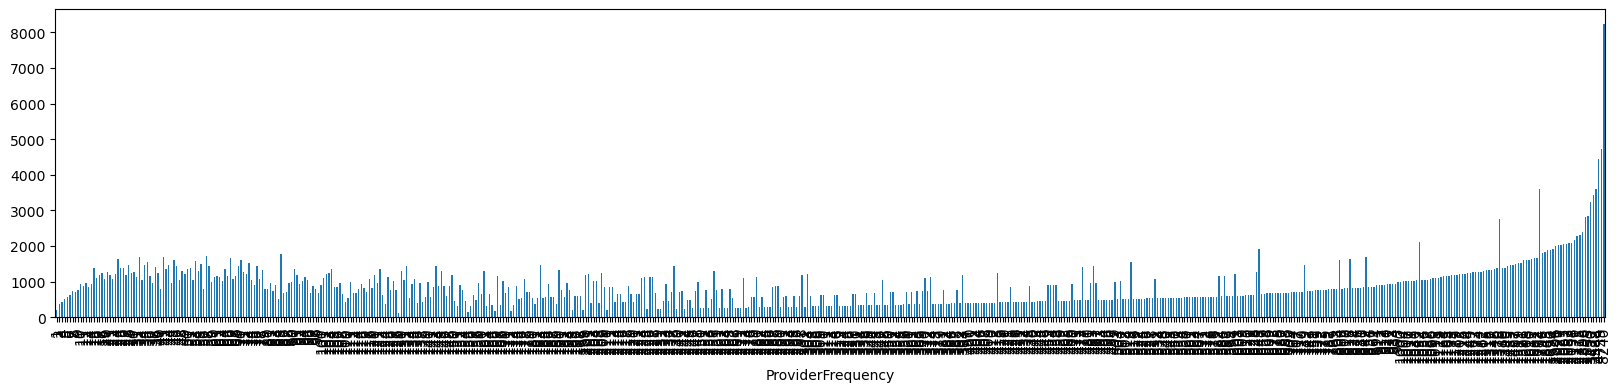

The median of the number of claims for each Provider: 372.00
The mean of the number of claims for each Provider: 837.81
The number of claims across different providers varies and does not follow any known distribution.


In [9]:
# add a new column
ProviderFrequency = df_outp.groupby(["Provider"]).count()["ClaimID"].reset_index()
ProviderFrequency.columns = ["Provider","ProviderFrequency"]
df_outp = pd.merge(df_outp,ProviderFrequency,on="Provider",how="left")

# The distribution of ProviderFrequency
plt.figure(figsize=(20, 4))
df_outp.groupby("ProviderFrequency").count()["ClaimID"].plot(kind="bar")
plt.show()

# The median and mean of the number of claims for provider with the same frequency in the dataset.
MedianProviderFrequency = df_outp["ProviderFrequency"].median()
MeanProviderFrequency = df_outp["ProviderFrequency"].mean()

# Observation: 
print(f"The median of the number of claims for each Provider: {MedianProviderFrequency:.2f}")
print(f"The mean of the number of claims for each Provider: {MeanProviderFrequency:.2f}")
print("The number of claims across different providers varies and does not follow any known distribution.")

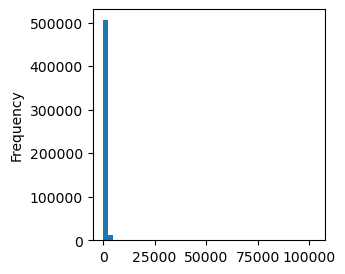

The median of the amount reimbursed by the payer: 80.00
The mean of the amount reimbursed by the payer: 286.33
Most claims received only a minimal reimbursement amount from the Payer.


In [10]:
# The distribution of InscClaimAmtReimbursed
plt.figure(figsize=(3, 3))
df_outp["InscClaimAmtReimbursed"].plot(kind="hist",bins= int(1 + 3.322 * np.log(nrow)))
plt.show()

# The median and mean of the amount reimbursed by the payer
MedianInscClaimAmtReimbursed = df_outp["InscClaimAmtReimbursed"].median()
MeanInscClaimAmtReimbursed = df_outp["InscClaimAmtReimbursed"].mean()

# Observation: 
print(f"The median of the amount reimbursed by the payer: {MedianInscClaimAmtReimbursed:.2f}")
print(f"The mean of the amount reimbursed by the payer: {MeanInscClaimAmtReimbursed:.2f}")
print("Most claims received only a minimal reimbursement amount from the Payer.")

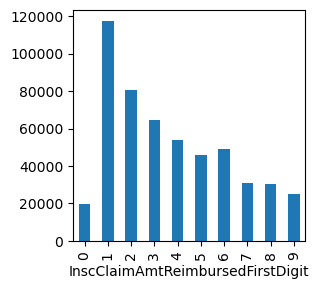

the first digit approximately follows the benford's law except the number of '6'


In [11]:
# add a new column
df_outp["InscClaimAmtReimbursedFirstDigit"] = df_outp["InscClaimAmtReimbursed"].apply(lambda x: str(x)[0])

# The pattern of the first digit of Insurance Claim Amount Reimbursed
plt.figure(figsize=(3, 3))
df_outp.groupby("InscClaimAmtReimbursedFirstDigit").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation: 
print("the first digit approximately follows the benford's law except the number of '6'")

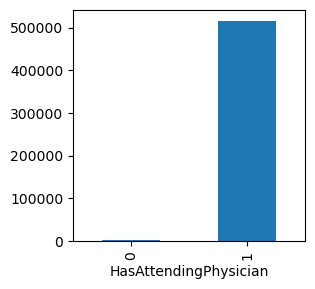

Most outpatient claims have the Attending Physicians


In [12]:
# add a new column
df_outp["HasAttendingPhysician"] = df_outp["AttendingPhysician"].notna().astype(int)

# The pattern of Attending Physician
plt.figure(figsize=(3, 3))
df_outp.groupby("HasAttendingPhysician").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation: 
print("Most outpatient claims have the Attending Physicians")

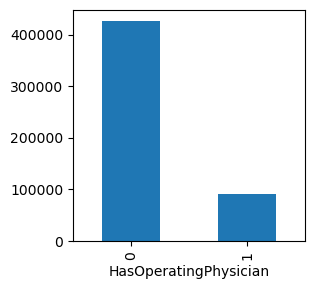

Only a few outpatient claims have the Operating Physicians, since most don't need operations.


In [13]:
# add a new column
df_outp["HasOperatingPhysician"] = df_outp["OperatingPhysician"].notna().astype(int)

# The pattern of Operating Physician
plt.figure(figsize=(3, 3))
df_outp.groupby("HasOperatingPhysician").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation: 
print("Only a few outpatient claims have the Operating Physicians, since most don't need operations.")

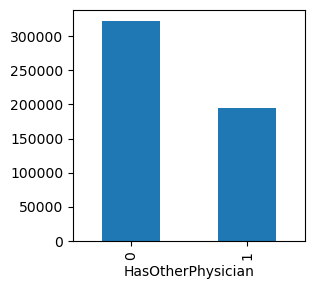

Less than a half claims have other Physicians.


In [14]:
# add a new column
df_outp["HasOtherPhysician"] = df_outp["OtherPhysician"].notna().astype(int)

# The pattern of Other Physician
plt.figure(figsize=(3, 3))
df_outp.groupby("HasOtherPhysician").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation: 
print("Less than a half claims have other Physicians.")

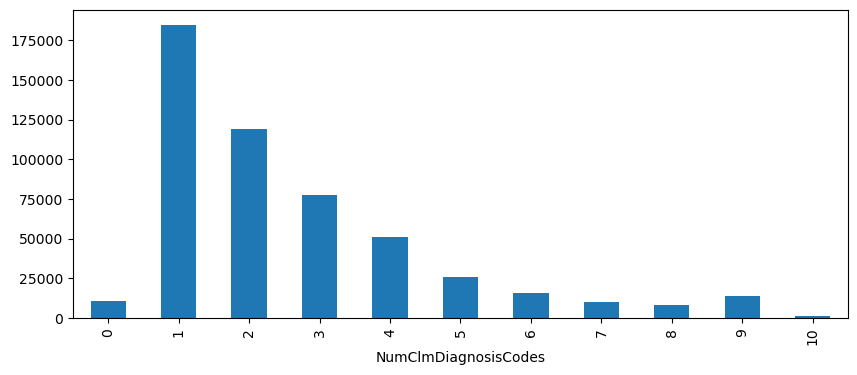

The median of the number of Admit Diagnosis Codes for each claim: 2.00
The mean of the number of Admit Diagnosis Codes for each claim: 2.61
Most claims have only 1 Claim Diagnosis Code and as the number of diagnosis codes per claim increases, the total number of such claims decreases..


In [15]:
# add a new column
df_outp["NumClmDiagnosisCodes"] = \
df_outp["ClmDiagnosisCode_1"].apply(lambda x:1 if pd.notnull(x) else 0) + \
df_outp["ClmDiagnosisCode_2"].apply(lambda x:1 if pd.notnull(x) else 0) + \
df_outp["ClmDiagnosisCode_3"].apply(lambda x:1 if pd.notnull(x) else 0) + \
df_outp["ClmDiagnosisCode_4"].apply(lambda x:1 if pd.notnull(x) else 0) + \
df_outp["ClmDiagnosisCode_5"].apply(lambda x:1 if pd.notnull(x) else 0) + \
df_outp["ClmDiagnosisCode_6"].apply(lambda x:1 if pd.notnull(x) else 0) + \
df_outp["ClmDiagnosisCode_7"].apply(lambda x:1 if pd.notnull(x) else 0) + \
df_outp["ClmDiagnosisCode_8"].apply(lambda x:1 if pd.notnull(x) else 0) + \
df_outp["ClmDiagnosisCode_9"].apply(lambda x:1 if pd.notnull(x) else 0) + \
df_outp["ClmDiagnosisCode_10"].apply(lambda x:1 if pd.notnull(x) else 0)

# The distribution of NumClmDiagnosisCodes
plt.figure(figsize=(10, 4))
df_outp.groupby("NumClmDiagnosisCodes").count()["ClaimID"].plot(kind="bar")
plt.show()

# The median and mean of the number of Admit Diagnosis Codes for claim
MedianNumClmDiagnosisCodes = df_outp["NumClmDiagnosisCodes"].median()
MeanNumClmDiagnosisCodes = df_outp["NumClmDiagnosisCodes"].mean()

# Observation: 
print(f"The median of the number of Admit Diagnosis Codes for each claim: {MedianNumClmDiagnosisCodes:.2f}")
print(f"The mean of the number of Admit Diagnosis Codes for each claim: {MeanNumClmDiagnosisCodes:.2f}")
print("Most claims have only 1 Claim Diagnosis Code and as the number of diagnosis codes per claim increases, the total number of such claims decreases..")

In [16]:
# add a new column
# add a new column
def CDC_to_TDC(value):
    category = None
    
    if pd.isnull(value):
        return "0"

    # purely numeric
    if value[0] not in ("V","E"):
        # get the first three digit of Claim Diagnosis Code
        first_three_digit = int(value[:3])
        if 1<= first_three_digit <= 9: category = "1"
        if 10<= first_three_digit <= 18: category = "2"
        if 20<= first_three_digit <= 27: category = "3"
        if 30<= first_three_digit <= 41: category = "4"
        if 42<= first_three_digit <= 42: category = "5"
        if 45<= first_three_digit <= 49: category = "6"
        if 50<= first_three_digit <= 59: category = "7"
        if 60<= first_three_digit <= 66: category = "8"
        if 70<= first_three_digit <= 79: category = "9"
        if 80<= first_three_digit <= 88: category = "10"
        if 90<= first_three_digit <= 99: category = "11"
        if 100<= first_three_digit <= 104: category = "12"
        if 110<= first_three_digit <= 118: category = "13"
        if 120<= first_three_digit <= 129: category = "14"
        if 130<= first_three_digit <= 136: category = "15"
        if 137<= first_three_digit <= 139: category = "16"
        if 140<= first_three_digit <= 149: category = "17"
        if 150<= first_three_digit <= 159: category = "18"
        if 160<= first_three_digit <= 165: category = "19"
        if 170<= first_three_digit <= 176: category = "20"
        if 179<= first_three_digit <= 189: category = "21"
        if 190<= first_three_digit <= 199: category = "22"
        if 200<= first_three_digit <= 208: category = "23"
        if 209<= first_three_digit <= 209: category = "24"
        if 210<= first_three_digit <= 229: category = "25"
        if 230<= first_three_digit <= 234: category = "26"
        if 235<= first_three_digit <= 238: category = "27"
        if 239<= first_three_digit <= 239: category = "28"
        if 240<= first_three_digit <= 246: category = "29"
        if 249<= first_three_digit <= 259: category = "30"
        if 260<= first_three_digit <= 269: category = "31"
        if 270<= first_three_digit <= 279: category = "32"
        if 280<= first_three_digit <= 289: category = "33"
        if 290<= first_three_digit <= 294: category = "34"
        if 295<= first_three_digit <= 299: category = "35"
        if 300<= first_three_digit <= 316: category = "36"
        if 317<= first_three_digit <= 319: category = "37"
        if 320<= first_three_digit <= 327: category = "38"
        if 330<= first_three_digit <= 337: category = "39"
        if 338<= first_three_digit <= 338: category = "40"
        if 339<= first_three_digit <= 339: category = "41"
        if 340<= first_three_digit <= 349: category = "42"
        if 350<= first_three_digit <= 359: category = "43"
        if 360<= first_three_digit <= 379: category = "44"
        if 380<= first_three_digit <= 389: category = "45"
        if 390<= first_three_digit <= 392: category = "46"
        if 393<= first_three_digit <= 398: category = "47"
        if 401<= first_three_digit <= 405: category = "48"
        if 410<= first_three_digit <= 414: category = "49"
        if 415<= first_three_digit <= 417: category = "50"
        if 420<= first_three_digit <= 429: category = "51"
        if 430<= first_three_digit <= 438: category = "52"
        if 440<= first_three_digit <= 449: category = "53"
        if 451<= first_three_digit <= 459: category = "54"
        if 460<= first_three_digit <= 466: category = "55"
        if 470<= first_three_digit <= 478: category = "56"
        if 480<= first_three_digit <= 488: category = "57"
        if 490<= first_three_digit <= 496: category = "58"
        if 500<= first_three_digit <= 508: category = "59"
        if 510<= first_three_digit <= 519: category = "60"
        if 520<= first_three_digit <= 529: category = "61"
        if 530<= first_three_digit <= 539: category = "62"
        if 540<= first_three_digit <= 543: category = "63"
        if 550<= first_three_digit <= 553: category = "64"
        if 555<= first_three_digit <= 558: category = "65"
        if 560<= first_three_digit <= 569: category = "66"
        if 570<= first_three_digit <= 579: category = "67"
        if 580<= first_three_digit <= 589: category = "68"
        if 590<= first_three_digit <= 599: category = "69"
        if 600<= first_three_digit <= 608: category = "70"
        if 610<= first_three_digit <= 611: category = "71"
        if 614<= first_three_digit <= 616: category = "72"
        if 617<= first_three_digit <= 629: category = "73"
        if 630<= first_three_digit <= 639: category = "74"
        if 640<= first_three_digit <= 649: category = "75"
        if 650<= first_three_digit <= 659: category = "76"
        if 660<= first_three_digit <= 669: category = "77"
        if 670<= first_three_digit <= 677: category = "78"
        if 678<= first_three_digit <= 679: category = "79"
        if 680<= first_three_digit <= 686: category = "80"
        if 690<= first_three_digit <= 698: category = "81"
        if 700<= first_three_digit <= 709: category = "82"
        if 710<= first_three_digit <= 719: category = "83"
        if 720<= first_three_digit <= 724: category = "84"
        if 725<= first_three_digit <= 729: category = "85"
        if 730<= first_three_digit <= 739: category = "86"
        if 740<= first_three_digit <= 759: category = "87"
        if 760<= first_three_digit <= 763: category = "88"
        if 764<= first_three_digit <= 779: category = "89"
        if 780<= first_three_digit <= 789: category = "90"
        if 790<= first_three_digit <= 796: category = "91"
        if 797<= first_three_digit <= 799: category = "92"
        if 800<= first_three_digit <= 804: category = "93"
        if 805<= first_three_digit <= 809: category = "94"
        if 810<= first_three_digit <= 819: category = "95"
        if 820<= first_three_digit <= 829: category = "96"
        if 830<= first_three_digit <= 839: category = "97"
        if 840<= first_three_digit <= 848: category = "98"
        if 850<= first_three_digit <= 854: category = "99"
        if 860<= first_three_digit <= 869: category = "100"
        if 870<= first_three_digit <= 879: category = "101"
        if 880<= first_three_digit <= 887: category = "102"
        if 890<= first_three_digit <= 897: category = "103"
        if 900<= first_three_digit <= 904: category = "104"
        if 905<= first_three_digit <= 909: category = "105"
        if 910<= first_three_digit <= 919: category = "106"
        if 920<= first_three_digit <= 924: category = "107"
        if 925<= first_three_digit <= 929: category = "108"
        if 930<= first_three_digit <= 939: category = "109"
        if 940<= first_three_digit <= 949: category = "110"
        if 950<= first_three_digit <= 957: category = "111"
        if 958<= first_three_digit <= 959: category = "112"
        if 960<= first_three_digit <= 979: category = "113"
        if 980<= first_three_digit <= 989: category = "114"
        if 990<= first_three_digit <= 995: category = "115"
        if 996<= first_three_digit <= 999: category = "116"

    # code beginning with E  
    elif value[0] == "E":
        # get the first three digit of Claim Diagnosis Code
        first_three_digit = int(value[1:4])
        if 0<= first_three_digit <= 0: category = "133"
        if 1<= first_three_digit <= 30: category = "134"
        if 800<= first_three_digit <= 807: category = "135"
        if 810<= first_three_digit <= 819: category = "136"
        if 820<= first_three_digit <= 825: category = "137"
        if 826<= first_three_digit <= 829: category = "138"
        if 830<= first_three_digit <= 838: category = "139"
        if 840<= first_three_digit <= 845: category = "140"
        if 846<= first_three_digit <= 849: category = "141"
        if 850<= first_three_digit <= 858: category = "142"
        if 860<= first_three_digit <= 869: category = "143"
        if 870<= first_three_digit <= 876: category = "144"
        if 878<= first_three_digit <= 879: category = "145"
        if 880<= first_three_digit <= 888: category = "146"
        if 890<= first_three_digit <= 899: category = "147"
        if 900<= first_three_digit <= 909: category = "148"
        if 910<= first_three_digit <= 915: category = "149"
        if 916<= first_three_digit <= 928: category = "150"
        if 929<= first_three_digit <= 929: category = "151"
        if 930<= first_three_digit <= 949: category = "152"
        if 950<= first_three_digit <= 959: category = "153"
        if 960<= first_three_digit <= 969: category = "154"
        if 970<= first_three_digit <= 978: category = "155"
        if 980<= first_three_digit <= 989: category = "156"
        if 990<= first_three_digit <= 999: category = "157"

    # code beginning with V
    elif value[0] == "V":
        # get the first two digit of Claim Diagnosis Code
        first_two_digit = int(value[1:3])
        if 1 <= first_two_digit <= 9: category = "117"
        if 10 <= first_two_digit <= 19: category = "118"
        if 20 <= first_two_digit <= 29: category = "119"
        if 30 <= first_two_digit <= 39: category = "120"
        if 40 <= first_two_digit <= 49: category = "121"
        if 50 <= first_two_digit <= 59: category = "122"
        if 60 <= first_two_digit <= 69: category = "123"
        if 70 <= first_two_digit <= 82: category = "124"
        if 83 <= first_two_digit <= 84: category = "125"
        if 85 <= first_two_digit <= 85: category = "126"
        if 86 <= first_two_digit <= 86: category = "127"
        if 87 <= first_two_digit <= 87: category = "128"
        if 88 <= first_two_digit <= 88: category = "129"
        if 89 <= first_two_digit <= 89: category = "130"
        if 90 <= first_two_digit <= 90: category = "131"
        if 91 <= first_two_digit <= 91: category = "132"
    
    if not category:
        categoru = 0

    return category

df_outp["PrincipalDiagnosticCategory"] = df_outp["ClmDiagnosisCode_1"].apply(CDC_to_TDC)

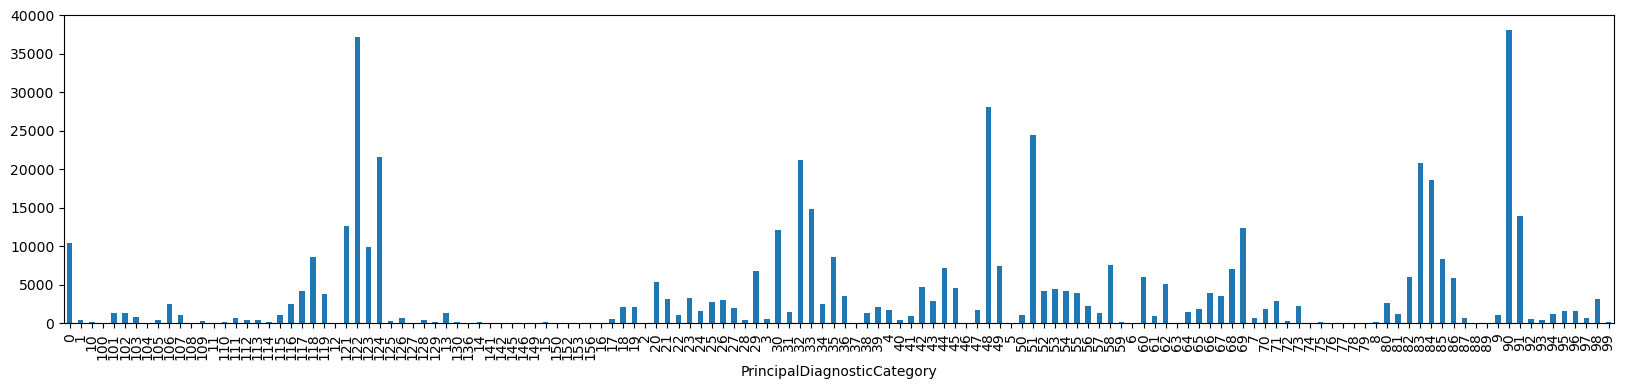

The number of claims across different Principal Diagnostic Category varies.


In [17]:
# The pattern of PrincipalDiagnosticCategory
plt.figure(figsize=(20, 4))
df_outp.groupby("PrincipalDiagnosticCategory").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation:
print("The number of claims across different Principal Diagnostic Category varies.")

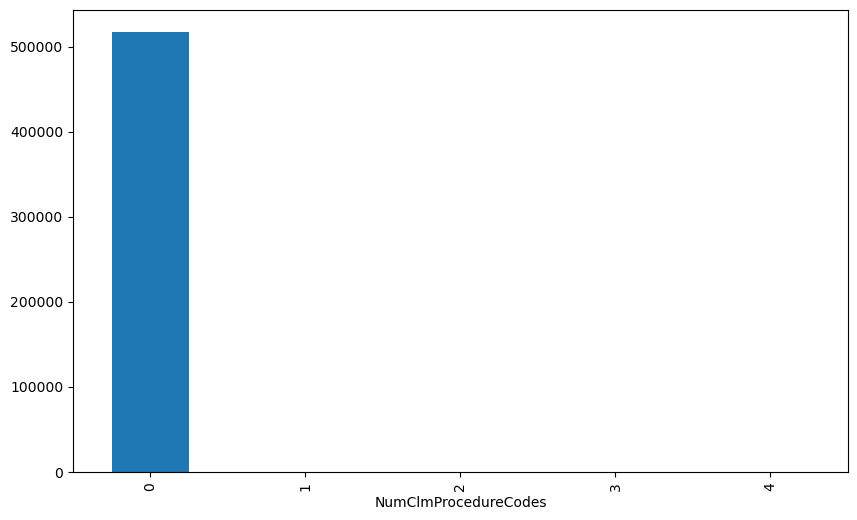

Almost all claims don't have ProcedureCode.


In [18]:
# add a new column
df_outp["NumClmProcedureCodes"] = \
df_outp["ClmProcedureCode_1"].apply(lambda x:1 if pd.notnull(x) else 0) + \
df_outp["ClmProcedureCode_2"].apply(lambda x:1 if pd.notnull(x) else 0) + \
df_outp["ClmProcedureCode_3"].apply(lambda x:1 if pd.notnull(x) else 0) + \
df_outp["ClmProcedureCode_4"].apply(lambda x:1 if pd.notnull(x) else 0)

# The distribution of NumClmProcedureCodes
plt.figure(figsize=(10, 6))
df_outp.groupby("NumClmProcedureCodes").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation:
print("Almost all claims don't have ProcedureCode.")

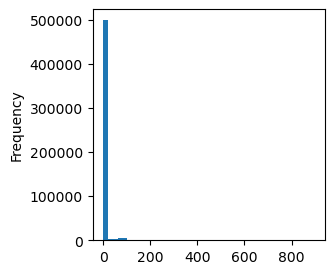

The median of the amount the beneficiary has to pay as part of the claim: 0.00
The mean of the amount the beneficiary has to pay as part of the claim: 2.78
Most claims don't require the beneficiary to pay as part of the claim.


In [19]:
# The distribution of InscClaimAmtReimbursed
plt.figure(figsize=(3, 3))
df_outp["DeductibleAmtPaid"].plot(kind="hist",bins= int(1 + 3.322 * np.log(nrow)))
plt.show()

# The median and mean of the amount reimbursed by the payer
MedianDeductibleAmtPaid = df_outp["DeductibleAmtPaid"].median()
MeanDeductibleAmtPaid = df_outp["DeductibleAmtPaid"].mean()

# Observation: 
print(f"The median of the amount the beneficiary has to pay as part of the claim: {MedianDeductibleAmtPaid:.2f}")
print(f"The mean of the amount the beneficiary has to pay as part of the claim: {MeanDeductibleAmtPaid:.2f}")
print("Most claims don't require the beneficiary to pay as part of the claim.")

Most claims don't have Claim Admit Diagnosis Code.


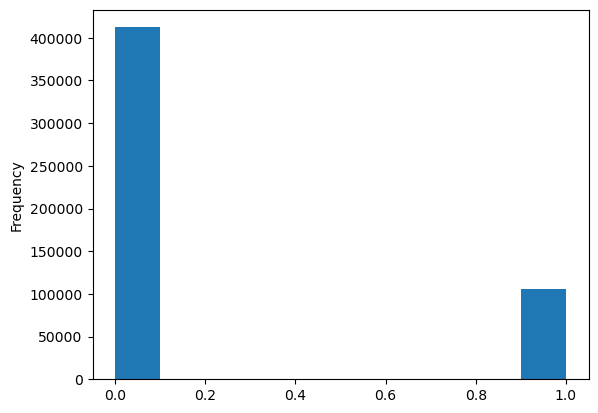

In [20]:
# The distribution of ClmAdmitDiagnosisCode
df_outp.ClmAdmitDiagnosisCode.apply(lambda x:1 if pd.notnull(x) else 0).plot(kind="hist")

# Observation:
print("Most claims don't have Claim Admit Diagnosis Code.")

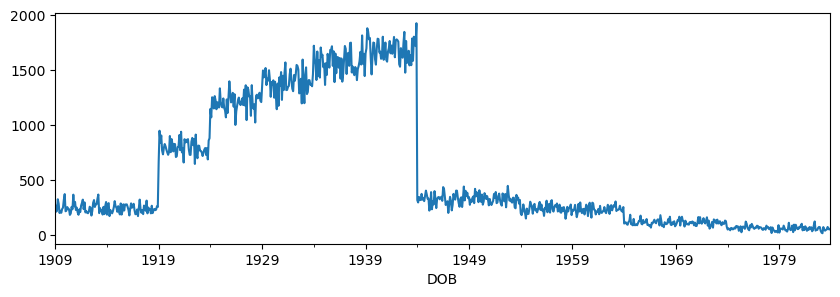

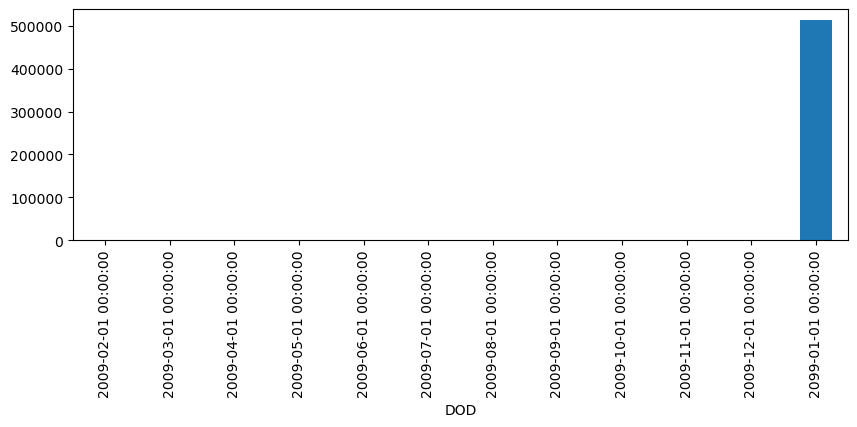

Most claims are from beneficiaries who are born before year 1945.
Most claims are from beneficiaries who are still alive.


In [21]:
# convert the DOB and DOD of claims
df_outp["DOB"] = pd.to_datetime(df_outp["DOB"])
df_outp["DOD"] = pd.to_datetime(df_outp["DOD"])
df_outp["DOD"] = df_outp["DOD"].apply(lambda x: pd.to_datetime("2099-1-1") if pd.isnull(x) else x)

# The distribution of DOB
plt.figure(figsize=(10, 3))
df_outp.groupby("DOB").count()["ClaimID"].plot(kind="line")
plt.show()

# The distribution of DOD
plt.figure(figsize=(10, 3))
df_outp.groupby("DOD").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation: 
print("Most claims are from beneficiaries who are born before year 1945.")
print("Most claims are from beneficiaries who are still alive.")

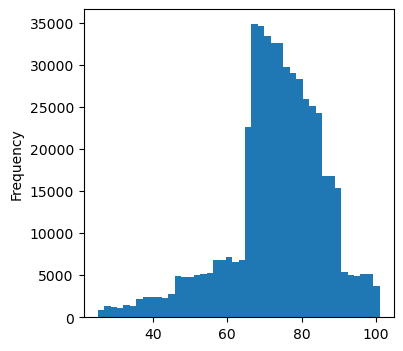

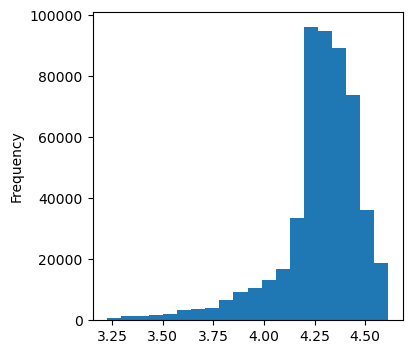

The median of the Age 74.17
The mean of the Age 73.27
Age distribution is not symmetric and shows a concentration of values on the right side the 65 mark.


In [22]:
# add a new column
df_outp["Age"] = df_outp["ClaimStartDt"] - df_outp["DOB"]
df_outp["Age"] = df_outp["Age"].apply(lambda x:x.days/365.25)

# The distribution of Age
plt.figure(figsize=(4, 4))
df_outp["Age"].plot(kind="hist",bins = int(1 + 3.322 * np.log(len(df_outp["Age"]))))
plt.show()

plt.figure(figsize=(4, 4))
df_outp[df_outp["Age"]>0]["Age"].apply(np.log).plot(kind="hist",bins = 20)
plt.show()

# The median and mean of the Age
MedianAge = df_outp["Age"].median()
MeanAge = df_outp["Age"].mean()

# Observation: 
print(f"The median of the Age {MedianAge:.2f}")
print(f"The mean of the Age {MeanAge:.2f}")
print("Age distribution is not symmetric and shows a concentration of values on the right side the 65 mark.")

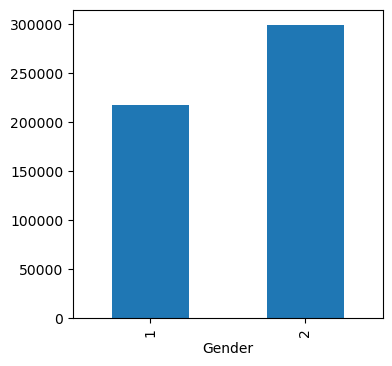

The number of claims for gender 2 is more than the ones for gender 1.


In [23]:
# The pattern of Gender
plt.figure(figsize=(4, 4))
df_outp.groupby("Gender").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation:
print("The number of claims for gender 2 is more than the ones for gender 1.")

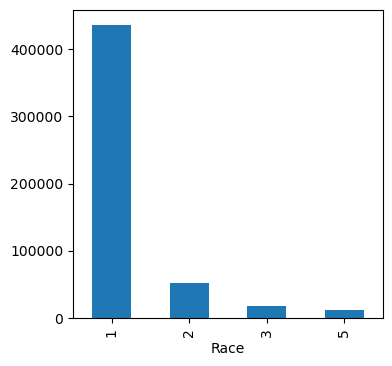

The number of claims for race 1 is much more than the others.


In [24]:
# The pattern of Race
plt.figure(figsize=(4, 4))
df_outp.groupby("Race").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation:
print("The number of claims for race 1 is much more than the others.")

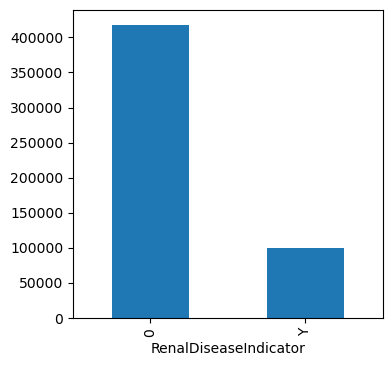

Most claims where beneficiaries did not have the renal disease.


In [25]:
# The pattern of RenalDiseaseIndicator
plt.figure(figsize=(4, 4))
df_outp.groupby("RenalDiseaseIndicator").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation:
print("Most claims where beneficiaries did not have the renal disease.")

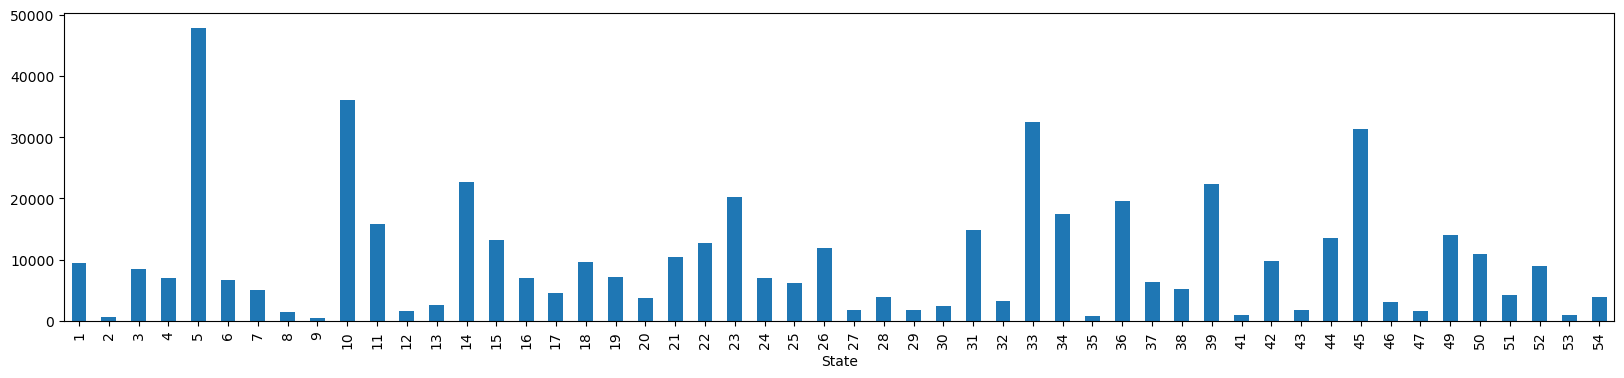

Some states have much more claims than other states, such the state 5, 10, 33, and 45.


In [26]:
# The pattern of State
plt.figure(figsize=(20, 4))
df_outp.groupby("State").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation:
print("Some states have much more claims than other states, such the state 5, 10, 33, and 45.")

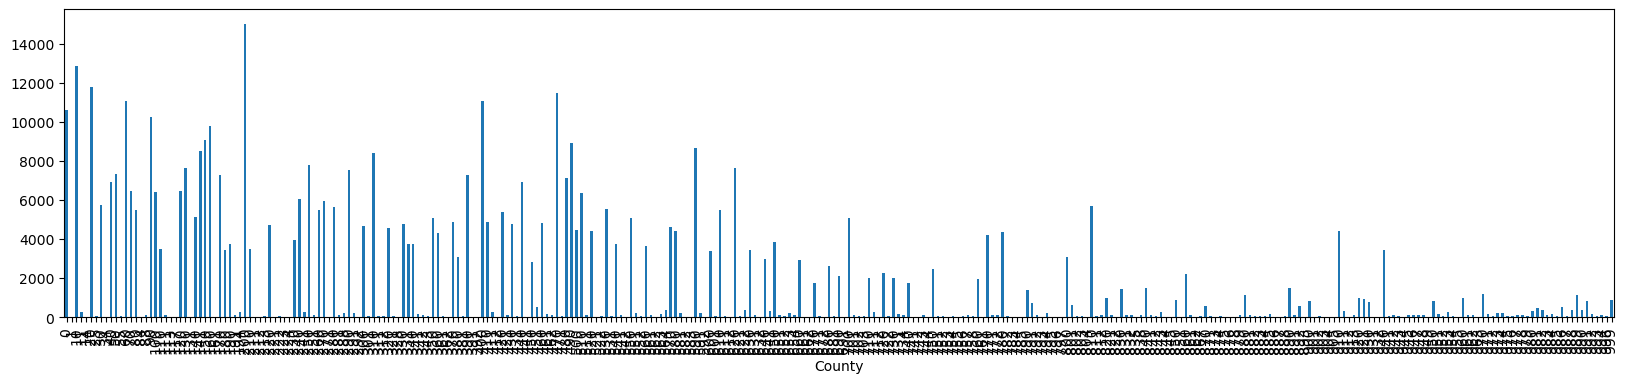

The number of claims across different County varies.


In [27]:
# The pattern of County
plt.figure(figsize=(20, 4))
df_outp.groupby("County").count()["ClaimID"].plot(kind="bar")
plt.show()

# Observation:
print("The number of claims across different County varies.")

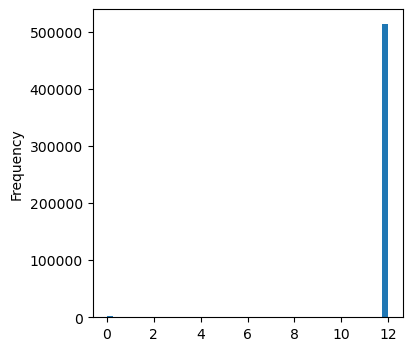

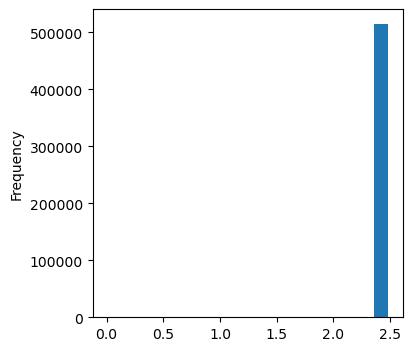

The median of the Age 12.00
The mean of the Age 11.93
Nearly all claim beneficiaries are covered for 12 months under Medicare Part A, rendering it useless for model training.


In [28]:
# The distribution of NoOfMonths_PartACov
plt.figure(figsize=(4, 4))
df_outp["NoOfMonths_PartACov"].plot(kind="hist",bins = int(1 + 3.322 * np.log(len(df_outp["NoOfMonths_PartACov"]))))
plt.show()

plt.figure(figsize=(4, 4))
df_outp[df_outp["NoOfMonths_PartACov"]>0]["NoOfMonths_PartACov"].apply(np.log).plot(kind="hist",bins = 20)
plt.show()

# The median and mean of the number of months that an individual has coverage under Medicare Part A
MedianNoOfMonths_PartACov = df_outp["NoOfMonths_PartACov"].median()
MeanNoOfMonths_PartACov = df_outp["NoOfMonths_PartACov"].mean()

# Observation: 
print(f"The median of the Age {MedianNoOfMonths_PartACov:.2f}")
print(f"The mean of the Age {MeanNoOfMonths_PartACov:.2f}")
print("Nearly all claim beneficiaries are covered for 12 months under Medicare Part A, rendering it useless for model training.")

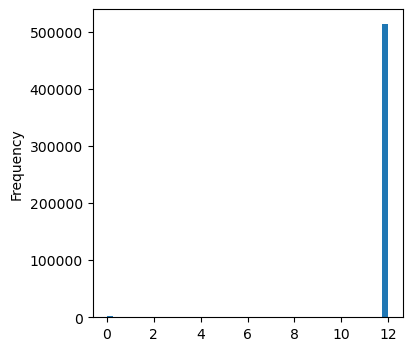

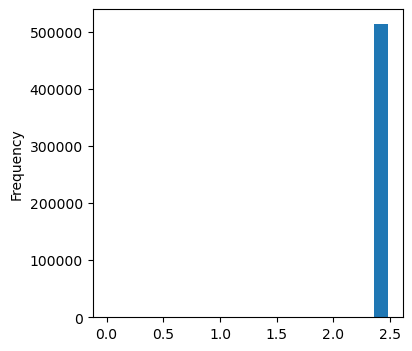

The median of the Age 12.00
The mean of the Age 11.94
Nearly all claim beneficiaries are covered for 12 months under Medicare Part B, rendering it useless for model training.


In [29]:
# The distribution of NoOfMonths_PartBCov
plt.figure(figsize=(4, 4))
df_outp["NoOfMonths_PartBCov"].plot(kind="hist",bins = int(1 + 3.322 * np.log(len(df_outp["NoOfMonths_PartBCov"]))))
plt.show()

plt.figure(figsize=(4, 4))
df_outp[df_outp["NoOfMonths_PartBCov"]>0]["NoOfMonths_PartBCov"].apply(np.log).plot(kind="hist",bins = 20)
plt.show()

# The median and mean of the number of months that an individual has coverage under Medicare Part A
MedianNoOfMonths_PartBCov = df_outp["NoOfMonths_PartBCov"].median()
MeanNoOfMonths_PartBCov = df_outp["NoOfMonths_PartBCov"].mean()

# Observation: 
print(f"The median of the Age {MedianNoOfMonths_PartBCov:.2f}")
print(f"The mean of the Age {MeanNoOfMonths_PartBCov:.2f}")
print("Nearly all claim beneficiaries are covered for 12 months under Medicare Part B, rendering it useless for model training.")

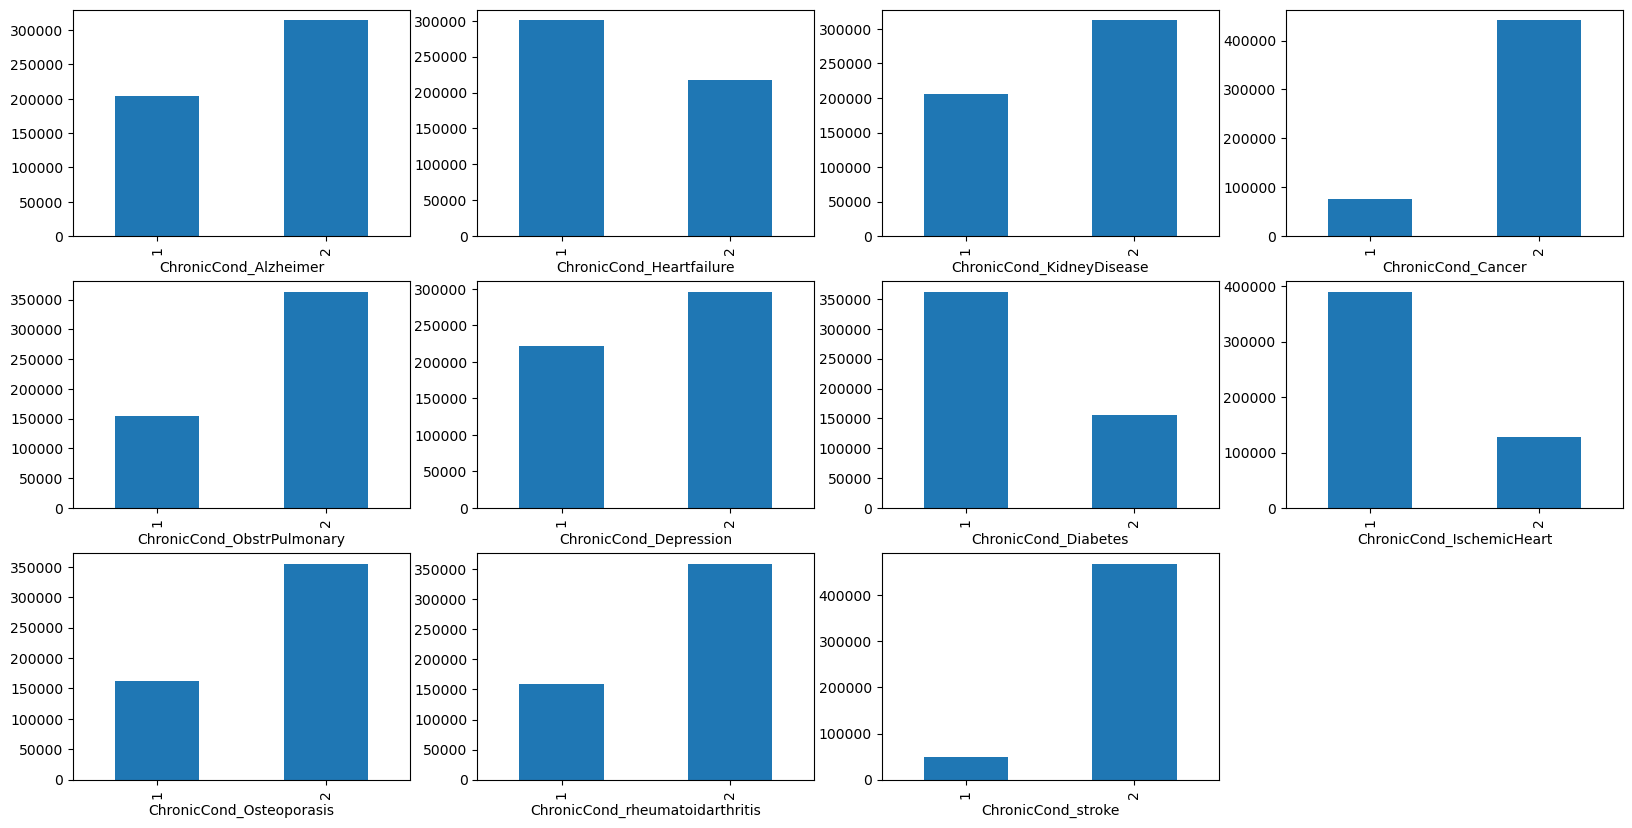

Each feature has only two categories, suggesting they probably represent the presence or absence of a specific disease.


In [30]:
# The pattern of the chronic conditions of various diseases
plt.figure(figsize=(20, 10))
plt.subplot(3, 4, 1)
df_outp.groupby("ChronicCond_Alzheimer").count()["ClaimID"].plot(kind="bar")

plt.subplot(3, 4, 2)
df_outp.groupby("ChronicCond_Heartfailure").count()["ClaimID"].plot(kind="bar")

plt.subplot(3, 4, 3)
df_outp.groupby("ChronicCond_KidneyDisease").count()["ClaimID"].plot(kind="bar")

plt.subplot(3, 4, 4)
df_outp.groupby("ChronicCond_Cancer").count()["ClaimID"].plot(kind="bar")

plt.subplot(3, 4, 5)
df_outp.groupby("ChronicCond_ObstrPulmonary").count()["ClaimID"].plot(kind="bar")

plt.subplot(3, 4, 6)
df_outp.groupby("ChronicCond_Depression").count()["ClaimID"].plot(kind="bar")

plt.subplot(3, 4, 7)
df_outp.groupby("ChronicCond_Diabetes").count()["ClaimID"].plot(kind="bar")

plt.subplot(3, 4, 8)
df_outp.groupby("ChronicCond_IschemicHeart").count()["ClaimID"].plot(kind="bar")

plt.subplot(3, 4, 9)
df_outp.groupby("ChronicCond_Osteoporasis").count()["ClaimID"].plot(kind="bar")

plt.subplot(3, 4, 10)
df_outp.groupby("ChronicCond_rheumatoidarthritis").count()["ClaimID"].plot(kind="bar")

plt.subplot(3, 4, 11)
df_outp.groupby("ChronicCond_stroke").count()["ClaimID"].plot(kind="bar")
plt.show()

#Observation:
print("Each feature has only two categories, suggesting they probably represent the presence or absence of a specific disease.")

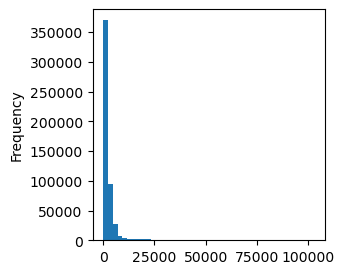

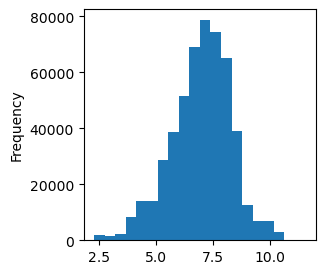

The median of the annual amount reimbursed for the treatment: 1200.00
The mean of the annual amount reimbursed for the treatment: 2308.01
The annual amount reimbursed for the treatment is positive skewed and approximately follows the log-normal distribution.


In [31]:
# The distribution of IPAnnualReimbursementAmt
plt.figure(figsize=(3, 3))
df_outp["OPAnnualReimbursementAmt"].plot(kind="hist",bins= int(1 + 3.322 * np.log(nrow)))
plt.show()

plt.figure(figsize=(3, 3))
df_outp[df_outp["OPAnnualReimbursementAmt"]>0]["OPAnnualReimbursementAmt"].apply(np.log).plot(kind="hist",bins= 20)
plt.show()

# The median and mean of the annual amount reimbursed for the treatment
MedianOPAnnualReimbursementAmt = df_outp["OPAnnualReimbursementAmt"].median()
MeanOPAnnualReimbursementAmt = df_outp["OPAnnualReimbursementAmt"].mean()

# Observation: 
print(f"The median of the annual amount reimbursed for the treatment: {MedianOPAnnualReimbursementAmt:.2f}")
print(f"The mean of the annual amount reimbursed for the treatment: {MeanOPAnnualReimbursementAmt:.2f}")
print("The annual amount reimbursed for the treatment is positive skewed and approximately follows the log-normal distribution.")

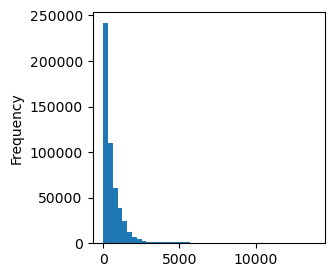

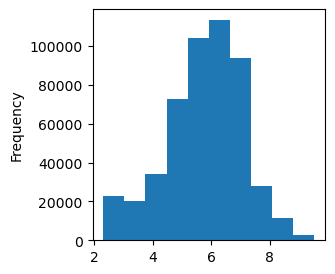

The median of the annual premium amount paid to the Insurance Agency towards the treatment: 350.00
The mean of the annual premium amount paid to the Insurance Agency towards the treatment: 659.11
The annual premium amount paid to the Insurance Agency towards the treatment is positive skewed and approximately follows the log-normal distribution. This skewness indicates a high frequency of zero values in the claims' Outpatient Annual Deductible Amount.


In [32]:
# The distribution of IPAnnualDeductibleAmt
plt.figure(figsize=(3, 3))
df_outp["OPAnnualDeductibleAmt"].plot(kind="hist",bins= int(1 + 3.322 * np.log(nrow)))
plt.show()

plt.figure(figsize=(3, 3))
df_outp[df_outp["OPAnnualDeductibleAmt"]>0]["OPAnnualDeductibleAmt"].apply(np.log).plot(kind="hist",bins= 10)
plt.show()

# The median and mean of the annual premium amount paid to the Insurance Agency towards the treatment
MedianOPAnnualDeductibleAmt = df_outp["OPAnnualDeductibleAmt"].median()
MeanOPAnnualDeductibleAmt = df_outp["OPAnnualDeductibleAmt"].mean()

# Observation: 
print(f"The median of the annual premium amount paid to the Insurance Agency towards the treatment: {MedianOPAnnualDeductibleAmt:.2f}")
print(f"The mean of the annual premium amount paid to the Insurance Agency towards the treatment: {MeanOPAnnualDeductibleAmt:.2f}")
print("The annual premium amount paid to the Insurance Agency towards the treatment is positive skewed and approximately follows the log-normal distribution. This skewness indicates a high frequency of zero values in the claims' Outpatient Annual Deductible Amount.")

##### (2). Analysis of interrelationships between categorical features and the target.

In [33]:
# The interrelationships between features and the target.
categorical_features = []
target = "PotentialFraud"

In [34]:
# BeneID and PotentialFraud
print("The categories of BeneID:",len(df_outp["BeneID"].unique()))

# Observation:
print("BeneID has high cardinality which is hard to aggregate, rendering it useless for model training")

The categories of BeneID: 133980
BeneID has high cardinality which is hard to aggregate, rendering it useless for model training


The categories of Provider: 5012


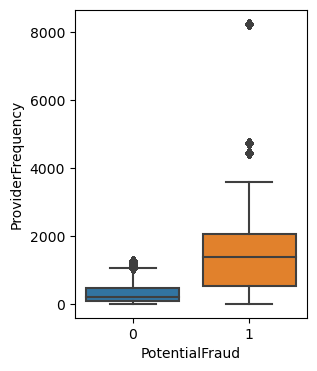

Provider has high cardinality, so we use ProviderFrequency for model training as it demonstrates a notable distinction between fraudulent and non-fraudulent claims.


In [35]:
# Provider and PotentialFraud
print("The categories of Provider:",len(df_outp["Provider"].unique()))

# ProviderFrequency and PotentialFraud
plt.figure(figsize=(3, 4))
sns.boxplot(x = "PotentialFraud",y = "ProviderFrequency",data =df_outp)
plt.show()

# Observation:
print("Provider has high cardinality, so we use ProviderFrequency for model training as it demonstrates a notable distinction between fraudulent and non-fraudulent claims.")

# incorporate the feature
# add to numerical_features

In [36]:
# Various Start Dates and PotentialFraud
ClaimStartDtMonth_fraud_count = df_outp.groupby(["ClaimStartDtMonth","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ClaimStartDtMonth_count = df_outp.groupby(["ClaimStartDtMonth"]).count()["ClaimID"].reset_index(name="aggregation")
ClaimStartDtMonth = pd.merge(ClaimStartDtMonth_fraud_count,ClaimStartDtMonth_count,on=["ClaimStartDtMonth"],how="left")
ClaimStartDtMonth["frequency"] = ClaimStartDtMonth["count"]/ClaimStartDtMonth["aggregation"]
ClaimStartDtMonth_pivot = ClaimStartDtMonth.pivot(index='ClaimStartDtMonth', columns='PotentialFraud', values='frequency')

ClaimStartDtWeekDay_fraud_count = df_outp.groupby(["ClaimStartDtWeekDay","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ClaimStartDtWeekDay_count = df_outp.groupby(["ClaimStartDtWeekDay"]).count()["ClaimID"].reset_index(name="aggregation")
ClaimStartDtWeekDay = pd.merge(ClaimStartDtWeekDay_fraud_count,ClaimStartDtWeekDay_count,on=["ClaimStartDtWeekDay"],how="left")
ClaimStartDtWeekDay["frequency"] = ClaimStartDtWeekDay["count"]/ClaimStartDtWeekDay["aggregation"]
ClaimStartDtWeekDay_pivot = ClaimStartDtWeekDay.pivot(index='ClaimStartDtWeekDay', columns='PotentialFraud', values='frequency')

ClaimStartDtDay_fraud_count = df_outp.groupby(["ClaimStartDtDay","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ClaimStartDtDay_count = df_outp.groupby(["ClaimStartDtDay"]).count()["ClaimID"].reset_index(name="aggregation")
ClaimStartDtDay = pd.merge(ClaimStartDtDay_fraud_count,ClaimStartDtDay_count,on=["ClaimStartDtDay"],how="left")
ClaimStartDtDay["frequency"] = ClaimStartDtDay["count"]/ClaimStartDtDay["aggregation"]
ClaimStartDtDay_pivot = ClaimStartDtDay.pivot(index='ClaimStartDtDay', columns='PotentialFraud', values='frequency')

The fraud rate does not exhibit significant difference between different types of start dates, rendering these features useless for model training.


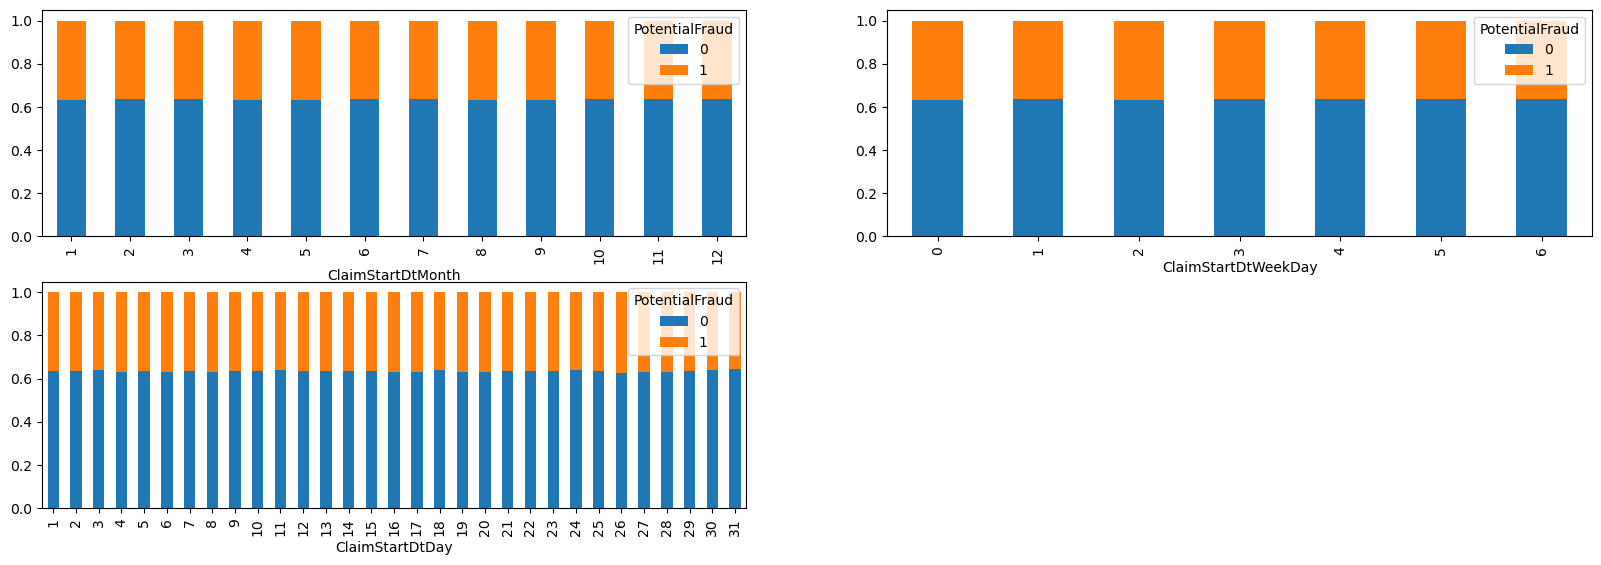

In [37]:
plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 1)
ClaimStartDtMonth_pivot.plot(kind='bar', stacked=True, ax=plt.gca())

plt.subplot(3, 2, 2)
ClaimStartDtWeekDay_pivot.plot(kind='bar', stacked=True, ax=plt.gca())

plt.subplot(3, 2, 3)
ClaimStartDtDay_pivot.plot(kind='bar', stacked=True, ax=plt.gca())

# Observation:
print("The fraud rate does not exhibit significant difference between different types of start dates, rendering these features useless for model training.")

In [38]:
# Various End Dates and PotentialFraud
ClaimEndDtMonth_fraud_count = df_outp.groupby(["ClaimEndDtMonth","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ClaimEndDtMonth_count = df_outp.groupby(["ClaimEndDtMonth"]).count()["ClaimID"].reset_index(name="aggregation")
ClaimEndDtMonth = pd.merge(ClaimEndDtMonth_fraud_count,ClaimEndDtMonth_count,on=["ClaimEndDtMonth"],how="left")
ClaimEndDtMonth["frequency"] = ClaimEndDtMonth["count"]/ClaimEndDtMonth["aggregation"]
ClaimEndDtMonth_pivot = ClaimEndDtMonth.pivot(index='ClaimEndDtMonth', columns='PotentialFraud', values='frequency')

ClaimEndDtWeekDay_fraud_count = df_outp.groupby(["ClaimEndDtWeekDay","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ClaimEndDtWeekDay_count = df_outp.groupby(["ClaimEndDtWeekDay"]).count()["ClaimID"].reset_index(name="aggregation")
ClaimEndDtWeekDay = pd.merge(ClaimEndDtWeekDay_fraud_count,ClaimEndDtWeekDay_count,on=["ClaimEndDtWeekDay"],how="left")
ClaimEndDtWeekDay["frequency"] = ClaimEndDtWeekDay["count"]/ClaimEndDtWeekDay["aggregation"]
ClaimEndDtWeekDay_pivot = ClaimEndDtWeekDay.pivot(index='ClaimEndDtWeekDay', columns='PotentialFraud', values='frequency')

ClaimEndDtDay_fraud_count = df_outp.groupby(["ClaimEndDtDay","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ClaimEndDtDay_count = df_outp.groupby(["ClaimEndDtDay"]).count()["ClaimID"].reset_index(name="aggregation")
ClaimEndDtDay = pd.merge(ClaimEndDtDay_fraud_count,ClaimEndDtDay_count,on=["ClaimEndDtDay"],how="left")
ClaimEndDtDay["frequency"] = ClaimEndDtDay["count"]/ClaimEndDtDay["aggregation"]
ClaimEndDtDay_pivot = ClaimEndDtDay.pivot(index='ClaimEndDtDay', columns='PotentialFraud', values='frequency')

The fraud rate does not exhibit significant difference between different types of end dates,rendering these features useless for model training.


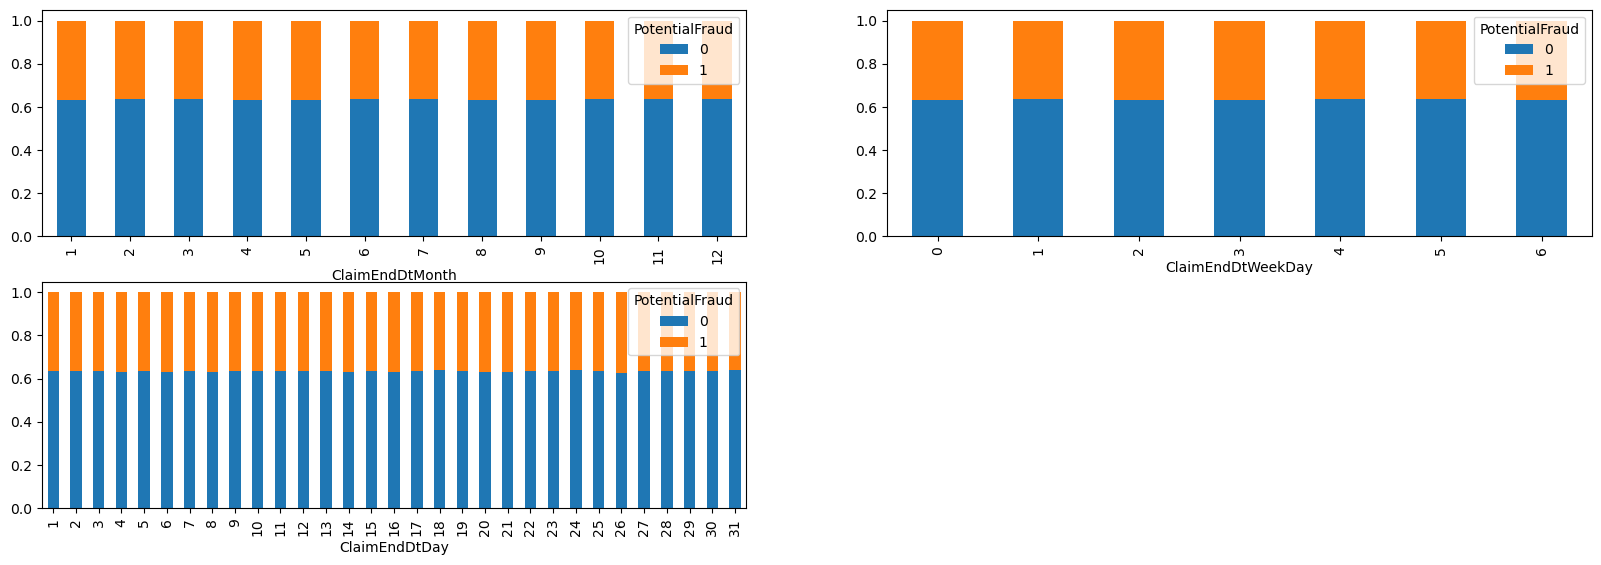

In [39]:
plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 1)
ClaimEndDtMonth_pivot.plot(kind='bar', stacked=True, ax=plt.gca())

plt.subplot(3, 2, 2)
ClaimEndDtWeekDay_pivot.plot(kind='bar', stacked=True, ax=plt.gca())

plt.subplot(3, 2, 3)
ClaimEndDtDay_pivot.plot(kind='bar', stacked=True, ax=plt.gca())

# Observation:
print("The fraud rate does not exhibit significant difference between different types of end dates,rendering these features useless for model training.")

<Figure size 600x600 with 0 Axes>

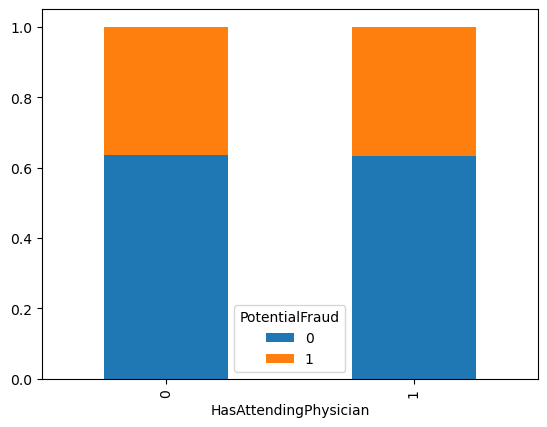

The fraud rate does not exhibit significant difference between claims with and without Attending Physicians, rendering this feature useless for model training.


In [40]:
# HasAttendingPhysician and PotentialFraud
HasAttendingPhysician_fraud_count = df_outp.groupby(["HasAttendingPhysician","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
HasAttendingPhysician_count = df_outp.groupby(["HasAttendingPhysician"]).count()["ClaimID"].reset_index(name="aggregation")
HasAttendingPhysician = pd.merge(HasAttendingPhysician_fraud_count,HasAttendingPhysician_count,on=["HasAttendingPhysician"],how="left")
HasAttendingPhysician["frequency"] = HasAttendingPhysician["count"]/HasAttendingPhysician["aggregation"]
HasAttendingPhysician_pivot = HasAttendingPhysician.pivot(index='HasAttendingPhysician', columns='PotentialFraud', values='frequency')

plt.figure(figsize=(6, 6))
HasAttendingPhysician_pivot.plot(kind='bar', stacked=True)
plt.show()

# Observation:
print("The fraud rate does not exhibit significant difference between claims with and without Attending Physicians, rendering this feature useless for model training.")

<Figure size 600x600 with 0 Axes>

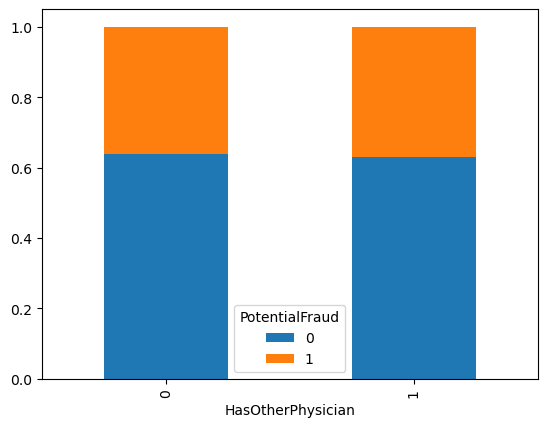

The fraud rate does not exhibit significant difference between claims with and without Other Physicians, rendering this feature useless for model training.


In [41]:
# HasOtherPhysician and PotentialFraud
HasOtherPhysician_fraud_count = df_outp.groupby(["HasOtherPhysician","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
HasOtherPhysician_count = df_outp.groupby(["HasOtherPhysician"]).count()["ClaimID"].reset_index(name="aggregation")
HasOtherPhysician = pd.merge(HasOtherPhysician_fraud_count,HasOtherPhysician_count,on=["HasOtherPhysician"],how="left")
HasOtherPhysician["frequency"] = HasOtherPhysician["count"]/HasOtherPhysician["aggregation"]
HasOtherPhysician_pivot = HasOtherPhysician.pivot(index='HasOtherPhysician', columns='PotentialFraud', values='frequency')

plt.figure(figsize=(6, 6))
HasOtherPhysician_pivot.plot(kind='bar', stacked=True)
plt.show()

# Observation:
print("The fraud rate does not exhibit significant difference between claims with and without Other Physicians, rendering this feature useless for model training.")

The categories of ClmDiagnosisCode_1: 10355


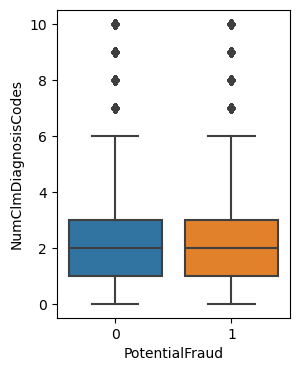

<Figure size 300x600 with 0 Axes>

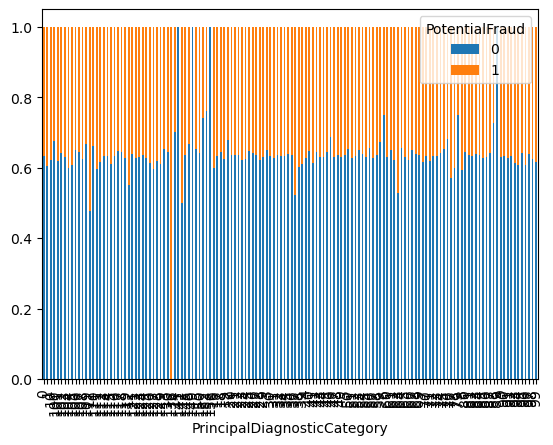

The number of missing values in ClmDiagnosisCode_2 : 195380
The number of missing values in ClmDiagnosisCode_3 : 314480
The number of missing values in ClmDiagnosisCode_4 : 392141
The number of missing values in ClmDiagnosisCode_5 : 443393
The number of missing values in ClmDiagnosisCode_6 : 468981
The number of missing values in ClmDiagnosisCode_7 : 484776
The number of missing values in ClmDiagnosisCode_8 : 494825
The number of missing values in ClmDiagnosisCode_9 : 502899
The number of missing values in ClmDiagnosisCode_10: 516654
ClmDiagnosisCode_1 has high cardinality, so we use PrincipalDiagnosticCategory for model training as it demonstrates a notable distinction in fruad rate across various categories.
ClmDiagnosisCode from 2 to 10 include too many missing values, rendering them useless for model training.


In [42]:
# ClmDiagnosisCode_1 and PotentialFraud
print("The categories of ClmDiagnosisCode_1:",len(df_outp["ClmDiagnosisCode_1"].unique()))

# NumClmDiagnosisCodes and PotentialFraud
plt.figure(figsize=(3, 4))
sns.boxplot(x = "PotentialFraud",y = "NumClmDiagnosisCodes",data =df_outp)
plt.show()

# PrincipalDiagnosticCategory and PotentialFraud
PDC_fraud_count = df_outp.groupby(["PrincipalDiagnosticCategory","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
PDC_count = df_outp.groupby(["PrincipalDiagnosticCategory"]).count()["ClaimID"].reset_index(name="aggregation")
PDC = pd.merge(PDC_fraud_count,PDC_count,on=["PrincipalDiagnosticCategory"],how="left")
PDC["frequency"] = PDC["count"]/PDC["aggregation"]
PDC_pivot = PDC.pivot(index='PrincipalDiagnosticCategory', columns='PotentialFraud', values='frequency')

plt.figure(figsize=(3, 6))
PDC_pivot.plot(kind='bar', stacked=True)
plt.show()

# ClmDiagnosisCode_2~10 and PotentialFraud
print("The number of missing values in ClmDiagnosisCode_2 :",df_outp["ClmDiagnosisCode_2"].apply(lambda x: 1 if pd.isnull(x) else 0).sum())
print("The number of missing values in ClmDiagnosisCode_3 :",df_outp["ClmDiagnosisCode_3"].apply(lambda x: 1 if pd.isnull(x) else 0).sum())
print("The number of missing values in ClmDiagnosisCode_4 :",df_outp["ClmDiagnosisCode_4"].apply(lambda x: 1 if pd.isnull(x) else 0).sum())
print("The number of missing values in ClmDiagnosisCode_5 :",df_outp["ClmDiagnosisCode_5"].apply(lambda x: 1 if pd.isnull(x) else 0).sum())
print("The number of missing values in ClmDiagnosisCode_6 :",df_outp["ClmDiagnosisCode_6"].apply(lambda x: 1 if pd.isnull(x) else 0).sum())
print("The number of missing values in ClmDiagnosisCode_7 :",df_outp["ClmDiagnosisCode_7"].apply(lambda x: 1 if pd.isnull(x) else 0).sum())
print("The number of missing values in ClmDiagnosisCode_8 :",df_outp["ClmDiagnosisCode_8"].apply(lambda x: 1 if pd.isnull(x) else 0).sum())
print("The number of missing values in ClmDiagnosisCode_9 :",df_outp["ClmDiagnosisCode_9"].apply(lambda x: 1 if pd.isnull(x) else 0).sum())
print("The number of missing values in ClmDiagnosisCode_10:",df_outp["ClmDiagnosisCode_10"].apply(lambda x: 1 if pd.isnull(x) else 0).sum())

# Observation:
print("ClmDiagnosisCode_1 has high cardinality, so we use PrincipalDiagnosticCategory for model training as it demonstrates a notable distinction in fruad rate across various categories.")
print("ClmDiagnosisCode from 2 to 10 include too many missing values, rendering them useless for model training.")

# incorporate the feature
categorical_features.append("PrincipalDiagnosticCategory")

<Figure size 600x600 with 0 Axes>

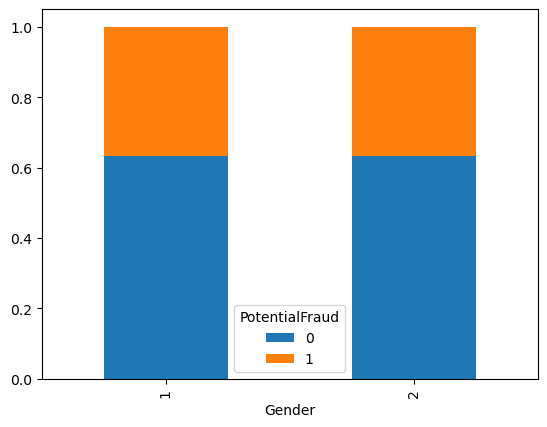

The fraud rate does not exhibit significant difference between claims involving beneficiaries of different genders, rendering this feature useless for model training.


In [43]:
# Gender and PotentialFraud
Gender_fraud_count = df_outp.groupby(["Gender","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
Gender_count = df_outp.groupby(["Gender"]).count()["ClaimID"].reset_index(name="aggregation")
Gender = pd.merge(Gender_fraud_count,Gender_count,on=["Gender"],how="left")
Gender["frequency"] = Gender["count"]/Gender["aggregation"]
Gender_pivot = Gender.pivot(index='Gender', columns='PotentialFraud', values='frequency')

plt.figure(figsize=(6, 6))
Gender_pivot.plot(kind='bar', stacked=True)
plt.show()

# Observation:
print("The fraud rate does not exhibit significant difference between claims involving beneficiaries of different genders, rendering this feature useless for model training.")

<Figure size 600x600 with 0 Axes>

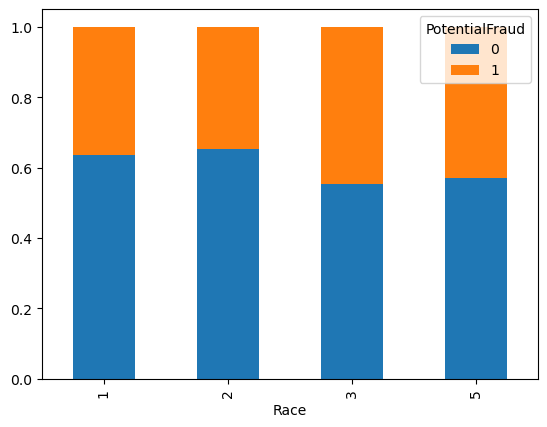

Race will be included in model training as it demonstrates some differences in fruad rate across various categories.


In [44]:
# Race and PotentialFraud
Race_fraud_count = df_outp.groupby(["Race","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
Race_count = df_outp.groupby(["Race"]).count()["ClaimID"].reset_index(name="aggregation")
Race = pd.merge(Race_fraud_count,Race_count,on=["Race"],how="left")
Race["frequency"] = Race["count"]/Race["aggregation"]
Race_pivot = Race.pivot(index='Race', columns='PotentialFraud', values='frequency')

plt.figure(figsize=(6, 6))
Race_pivot.plot(kind='bar', stacked=True)
plt.show()

# Observation:
print("Race will be included in model training as it demonstrates some differences in fruad rate across various categories.")
# incorporate the feature
categorical_features.append("Race")

<Figure size 600x600 with 0 Axes>

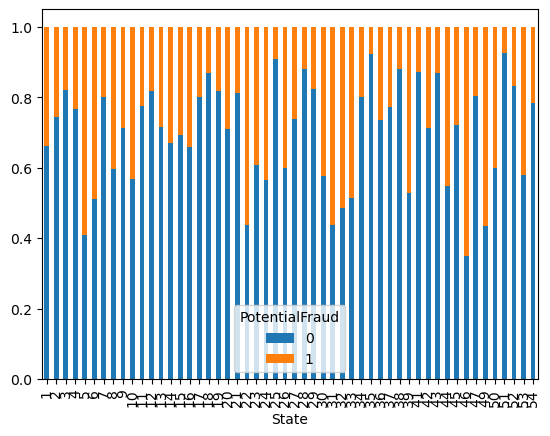

State will be included in model training as it demonstrates a notable distinction in fruad rate across various categories.


In [45]:
# State and PotentialFraud
State_fraud_count = df_outp.groupby(["State","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
State_count = df_outp.groupby(["State"]).count()["ClaimID"].reset_index(name="aggregation")
State = pd.merge(State_fraud_count,State_count,on=["State"],how="left")
State["frequency"] = State["count"]/State["aggregation"]
State_pivot = State.pivot(index='State', columns='PotentialFraud', values='frequency')

plt.figure(figsize=(6, 6))
State_pivot.plot(kind='bar', stacked=True)
plt.show()

# Observation:
print("State will be included in model training as it demonstrates a notable distinction in fruad rate across various categories.")

# incorporate the feature
categorical_features.append("State")

In [46]:
# County and PotentialFraud
print("The categories of County:",len(df_outp["County"].unique()))

# Observation: 
print("County will be excluded from the model training due to its high cardinality, and since State already provides sufficient geographical representation in the model.")

The categories of County: 313
County will be excluded from the model training due to its high cardinality, and since State already provides sufficient geographical representation in the model.


<Figure size 600x600 with 0 Axes>

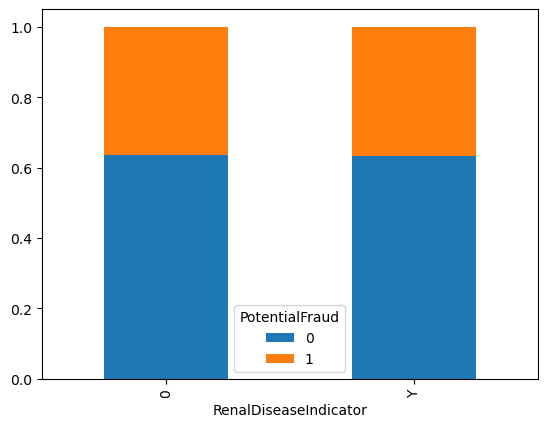

The fraud rate does not exhibit significant difference between claims involving beneficiaries with or without RenalDiseaseIndicator, rendering this feature useless for model training.


In [47]:
# RenalDiseaseIndicator and PotentialFraud
RenalDiseaseIndicator_fraud_count = df_outp.groupby(["RenalDiseaseIndicator","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
RenalDiseaseIndicator_count = df_outp.groupby(["RenalDiseaseIndicator"]).count()["ClaimID"].reset_index(name="aggregation")
RenalDiseaseIndicator = pd.merge(RenalDiseaseIndicator_fraud_count,RenalDiseaseIndicator_count,on=["RenalDiseaseIndicator"],how="left")
RenalDiseaseIndicator["frequency"] = RenalDiseaseIndicator["count"]/RenalDiseaseIndicator["aggregation"]
RenalDiseaseIndicator_pivot = RenalDiseaseIndicator.pivot(index='RenalDiseaseIndicator', columns='PotentialFraud', values='frequency')

plt.figure(figsize=(6, 6))
RenalDiseaseIndicator_pivot.plot(kind='bar', stacked=True)
plt.show()

# Observation:
print("The fraud rate does not exhibit significant difference between claims involving beneficiaries with or without RenalDiseaseIndicator, rendering this feature useless for model training.")

In [48]:
# Chronic Condition of various diseases and PotentialFraud
ChronicCond_Alzheimer_fraud_count = df_outp.groupby(["ChronicCond_Alzheimer","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ChronicCond_Alzheimer_count = df_outp.groupby(["ChronicCond_Alzheimer"]).count()["ClaimID"].reset_index(name="aggregation")
ChronicCond_Alzheimer = pd.merge(ChronicCond_Alzheimer_fraud_count,ChronicCond_Alzheimer_count,on=["ChronicCond_Alzheimer"],how="left")
ChronicCond_Alzheimer["frequency"] = ChronicCond_Alzheimer["count"]/ChronicCond_Alzheimer["aggregation"]
ChronicCond_Alzheimer_pivot = ChronicCond_Alzheimer.pivot(index='ChronicCond_Alzheimer', columns='PotentialFraud', values='frequency')

ChronicCond_Heartfailure_fraud_count = df_outp.groupby(["ChronicCond_Heartfailure","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ChronicCond_Heartfailure_count = df_outp.groupby(["ChronicCond_Heartfailure"]).count()["ClaimID"].reset_index(name="aggregation")
ChronicCond_Heartfailure = pd.merge(ChronicCond_Heartfailure_fraud_count,ChronicCond_Heartfailure_count,on=["ChronicCond_Heartfailure"],how="left")
ChronicCond_Heartfailure["frequency"] = ChronicCond_Heartfailure["count"]/ChronicCond_Heartfailure["aggregation"]
ChronicCond_Heartfailure_pivot = ChronicCond_Heartfailure.pivot(index='ChronicCond_Heartfailure', columns='PotentialFraud', values='frequency')

ChronicCond_KidneyDisease_fraud_count = df_outp.groupby(["ChronicCond_KidneyDisease","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ChronicCond_KidneyDisease_count = df_outp.groupby(["ChronicCond_KidneyDisease"]).count()["ClaimID"].reset_index(name="aggregation")
ChronicCond_KidneyDisease = pd.merge(ChronicCond_KidneyDisease_fraud_count,ChronicCond_KidneyDisease_count,on=["ChronicCond_KidneyDisease"],how="left")
ChronicCond_KidneyDisease["frequency"] = ChronicCond_KidneyDisease["count"]/ChronicCond_KidneyDisease["aggregation"]
ChronicCond_KidneyDisease_pivot = ChronicCond_KidneyDisease.pivot(index='ChronicCond_KidneyDisease', columns='PotentialFraud', values='frequency')

ChronicCond_Cancer_fraud_count = df_outp.groupby(["ChronicCond_Cancer","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ChronicCond_Cancer_count = df_outp.groupby(["ChronicCond_Cancer"]).count()["ClaimID"].reset_index(name="aggregation")
ChronicCond_Cancer = pd.merge(ChronicCond_Cancer_fraud_count,ChronicCond_Cancer_count,on=["ChronicCond_Cancer"],how="left")
ChronicCond_Cancer["frequency"] = ChronicCond_Cancer["count"]/ChronicCond_Cancer["aggregation"]
ChronicCond_Cancer_pivot = ChronicCond_Cancer.pivot(index='ChronicCond_Cancer', columns='PotentialFraud', values='frequency')

ChronicCond_ObstrPulmonary_fraud_count = df_outp.groupby(["ChronicCond_ObstrPulmonary","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ChronicCond_ObstrPulmonary_count = df_outp.groupby(["ChronicCond_ObstrPulmonary"]).count()["ClaimID"].reset_index(name="aggregation")
ChronicCond_ObstrPulmonary = pd.merge(ChronicCond_ObstrPulmonary_fraud_count,ChronicCond_ObstrPulmonary_count,on=["ChronicCond_ObstrPulmonary"],how="left")
ChronicCond_ObstrPulmonary["frequency"] = ChronicCond_ObstrPulmonary["count"]/ChronicCond_ObstrPulmonary["aggregation"]
ChronicCond_ObstrPulmonary_pivot = ChronicCond_ObstrPulmonary.pivot(index='ChronicCond_ObstrPulmonary', columns='PotentialFraud', values='frequency')

ChronicCond_Depression_fraud_count = df_outp.groupby(["ChronicCond_Depression","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ChronicCond_Depression_count = df_outp.groupby(["ChronicCond_Depression"]).count()["ClaimID"].reset_index(name="aggregation")
ChronicCond_Depression = pd.merge(ChronicCond_Depression_fraud_count,ChronicCond_Depression_count,on=["ChronicCond_Depression"],how="left")
ChronicCond_Depression["frequency"] = ChronicCond_Depression["count"]/ChronicCond_Depression["aggregation"]
ChronicCond_Depression_pivot = ChronicCond_Depression.pivot(index='ChronicCond_Depression', columns='PotentialFraud', values='frequency')

ChronicCond_Diabetes_fraud_count = df_outp.groupby(["ChronicCond_Diabetes","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ChronicCond_Diabetes_count = df_outp.groupby(["ChronicCond_Diabetes"]).count()["ClaimID"].reset_index(name="aggregation")
ChronicCond_Diabetes = pd.merge(ChronicCond_Diabetes_fraud_count,ChronicCond_Diabetes_count,on=["ChronicCond_Diabetes"],how="left")
ChronicCond_Diabetes["frequency"] = ChronicCond_Diabetes["count"]/ChronicCond_Diabetes["aggregation"]
ChronicCond_Diabetes_pivot = ChronicCond_Diabetes.pivot(index='ChronicCond_Diabetes', columns='PotentialFraud', values='frequency')

ChronicCond_IschemicHeart_fraud_count = df_outp.groupby(["ChronicCond_IschemicHeart","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ChronicCond_IschemicHeart_count = df_outp.groupby(["ChronicCond_IschemicHeart"]).count()["ClaimID"].reset_index(name="aggregation")
ChronicCond_IschemicHeart = pd.merge(ChronicCond_IschemicHeart_fraud_count,ChronicCond_IschemicHeart_count,on=["ChronicCond_IschemicHeart"],how="left")
ChronicCond_IschemicHeart["frequency"] = ChronicCond_IschemicHeart["count"]/ChronicCond_IschemicHeart["aggregation"]
ChronicCond_IschemicHeart_pivot = ChronicCond_IschemicHeart.pivot(index='ChronicCond_IschemicHeart', columns='PotentialFraud', values='frequency')

ChronicCond_Osteoporasis_fraud_count = df_outp.groupby(["ChronicCond_Osteoporasis","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ChronicCond_Osteoporasis_count = df_outp.groupby(["ChronicCond_Osteoporasis"]).count()["ClaimID"].reset_index(name="aggregation")
ChronicCond_Osteoporasis = pd.merge(ChronicCond_Osteoporasis_fraud_count,ChronicCond_Osteoporasis_count,on=["ChronicCond_Osteoporasis"],how="left")
ChronicCond_Osteoporasis["frequency"] = ChronicCond_Osteoporasis["count"]/ChronicCond_Osteoporasis["aggregation"]
ChronicCond_Osteoporasis_pivot = ChronicCond_Osteoporasis.pivot(index='ChronicCond_Osteoporasis', columns='PotentialFraud', values='frequency')

ChronicCond_rheumatoidarthritis_fraud_count = df_outp.groupby(["ChronicCond_rheumatoidarthritis","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ChronicCond_rheumatoidarthritis_count = df_outp.groupby(["ChronicCond_rheumatoidarthritis"]).count()["ClaimID"].reset_index(name="aggregation")
ChronicCond_rheumatoidarthritis = pd.merge(ChronicCond_rheumatoidarthritis_fraud_count,ChronicCond_rheumatoidarthritis_count,on=["ChronicCond_rheumatoidarthritis"],how="left")
ChronicCond_rheumatoidarthritis["frequency"] = ChronicCond_rheumatoidarthritis["count"]/ChronicCond_rheumatoidarthritis["aggregation"]
ChronicCond_rheumatoidarthritis_pivot = ChronicCond_rheumatoidarthritis.pivot(index='ChronicCond_rheumatoidarthritis', columns='PotentialFraud', values='frequency')

ChronicCond_stroke_fraud_count = df_outp.groupby(["ChronicCond_stroke","PotentialFraud"]).count()["ClaimID"].reset_index(name="count")
ChronicCond_stroke_count = df_outp.groupby(["ChronicCond_stroke"]).count()["ClaimID"].reset_index(name="aggregation")
ChronicCond_stroke = pd.merge(ChronicCond_stroke_fraud_count,ChronicCond_stroke_count,on=["ChronicCond_stroke"],how="left")
ChronicCond_stroke["frequency"] = ChronicCond_stroke["count"]/ChronicCond_stroke["aggregation"]
ChronicCond_stroke_pivot = ChronicCond_stroke.pivot(index='ChronicCond_stroke', columns='PotentialFraud', values='frequency')

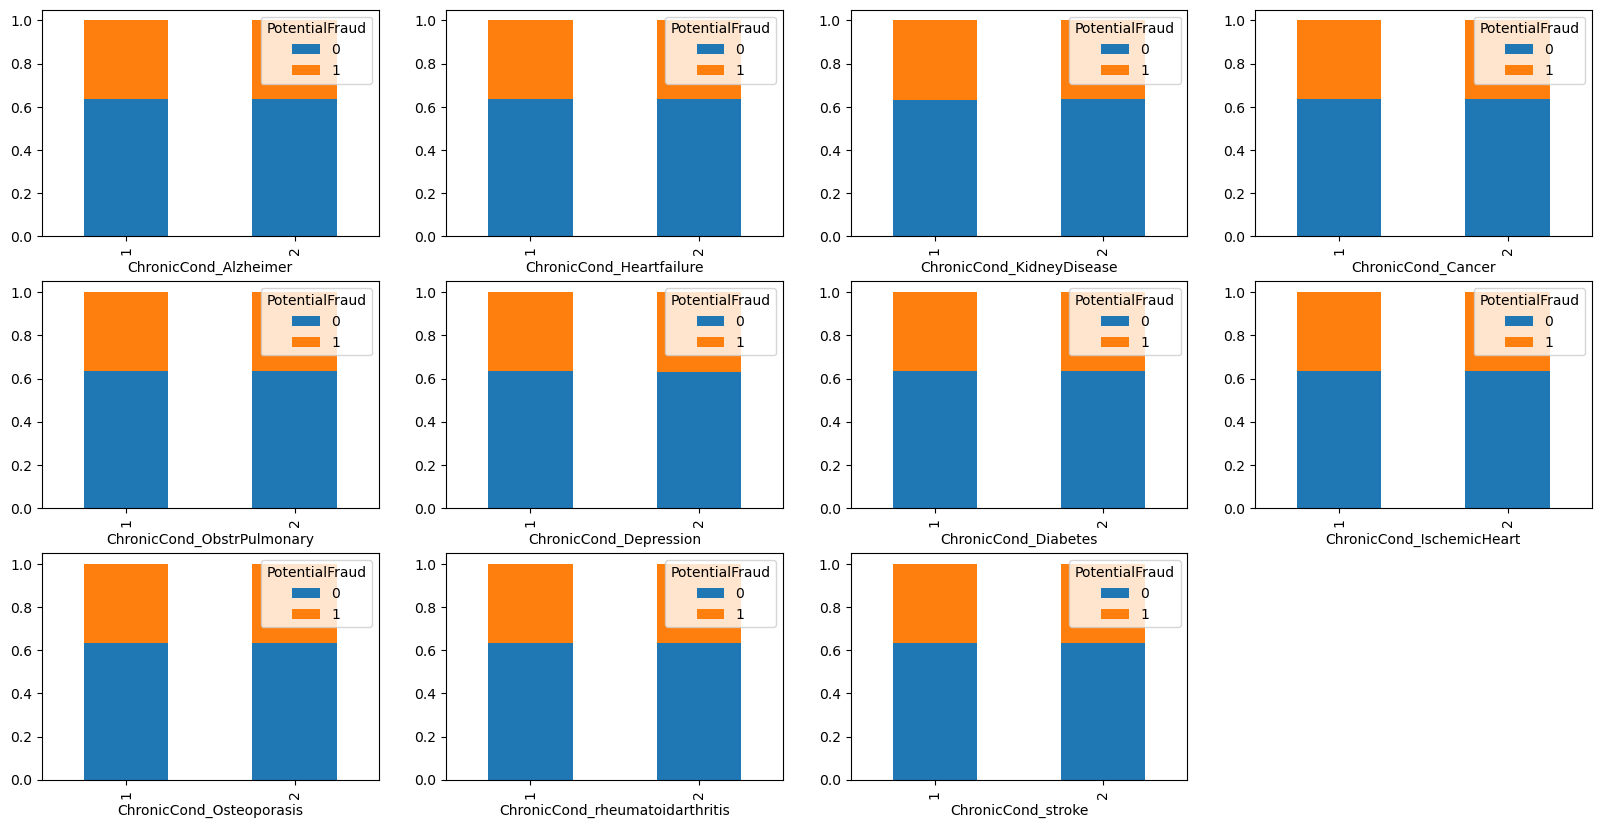

The fraud rate does not exhibit significant difference between claims involving beneficiaries with or without any Chronic Condition of diseases,rendering these features useless for model training.


In [49]:
plt.figure(figsize=(20, 10))

plt.subplot(3, 4, 1)
ChronicCond_Alzheimer_pivot.plot(kind='bar', stacked=True, ax=plt.gca())

plt.subplot(3, 4, 2)
ChronicCond_Heartfailure_pivot.plot(kind='bar', stacked=True, ax=plt.gca())


plt.subplot(3, 4, 3)
ChronicCond_KidneyDisease_pivot.plot(kind='bar', stacked=True, ax=plt.gca())


plt.subplot(3, 4, 4)
ChronicCond_Cancer_pivot.plot(kind='bar', stacked=True, ax=plt.gca())


plt.subplot(3, 4, 5)
ChronicCond_ObstrPulmonary_pivot.plot(kind='bar', stacked=True, ax=plt.gca())


plt.subplot(3, 4, 6)
ChronicCond_Depression_pivot.plot(kind='bar', stacked=True, ax=plt.gca())


plt.subplot(3, 4, 7)
ChronicCond_Diabetes_pivot.plot(kind='bar', stacked=True, ax=plt.gca())


plt.subplot(3, 4, 8)
ChronicCond_IschemicHeart_pivot.plot(kind='bar', stacked=True, ax=plt.gca())

plt.subplot(3, 4, 9)
ChronicCond_Osteoporasis_pivot.plot(kind='bar', stacked=True, ax=plt.gca())


plt.subplot(3, 4, 10)
ChronicCond_rheumatoidarthritis_pivot.plot(kind='bar', stacked=True, ax=plt.gca())


plt.subplot(3, 4, 11)
ChronicCond_stroke_pivot.plot(kind='bar', stacked=True, ax=plt.gca())
plt.show()

# Observation:
print("The fraud rate does not exhibit significant difference between claims involving beneficiaries with or without any Chronic Condition of diseases,rendering these features useless for model training.")

##### (3). Analysis of correlation between numerical features and with the target.

In [50]:
# The correlation between features and the target.
numerical_features = ["ClaimStartDt","ClaimEndDt","InscClaimAmtReimbursed","ProviderFrequency","DeductibleAmtPaid","DOB","DOD","Age","OPAnnualReimbursementAmt","OPAnnualDeductibleAmt"]
numerical_df = df_outp[numerical_features + [target]]
numerical_corr = numerical_df.corr()
numerical_corr

,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,ProviderFrequency,DeductibleAmtPaid,DOB,DOD,Age,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
ClaimStartDt,1.000000,0.998979,-0.004705,-0.001070,0.004380,0.003875,0.051560,0.018060,-0.019449,-0.019295,-0.000818
ClaimEndDt,0.998979,1.000000,0.005365,-0.001115,0.004088,0.003549,0.051599,0.018363,-0.004895,-0.004950,-0.000723
InscClaimAmtReimbursed,-0.004705,0.005365,1.000000,-0.001567,0.092015,-0.002199,-0.000525,0.002095,0.392227,0.260401,0.000939
ProviderFrequency,-0.001070,-0.001115,-0.001567,1.000000,-0.000288,-0.015103,0.001691,0.015077,0.001690,0.002829,0.533134
DeductibleAmtPaid,0.004380,0.004088,0.092015,-0.000288,1.000000,0.004517,0.001569,-0.004420,0.008756,0.007344,-0.000226
DOB,0.003875,0.003549,-0.002199,-0.015103,0.004517,1.000000,0.008181,-0.999759,-0.002193,-0.002131,-0.007728
DOD,0.051560,0.051599,-0.000525,0.001691,0.001569,0.008181,1.000000,-0.007048,0.008485,0.011741,0.001255
Age,0.018060,0.018363,0.002095,0.015077,-0.004420,-0.999759,-0.007048,1.000000,0.001767,0.001707,0.007709
OPAnnualReimbursementAmt,-0.019449,-0.004895,0.392227,0.001690,0.008756,-0.002193,0.008485,0.001767,1.000000,0.839705,0.004533
OPAnnualDeductibleAmt,-0.019295,-0.004950,0.260401,0.002829,0.007344,-0.002131,0.011741,0.001707,0.839705,1.000000,0.006658


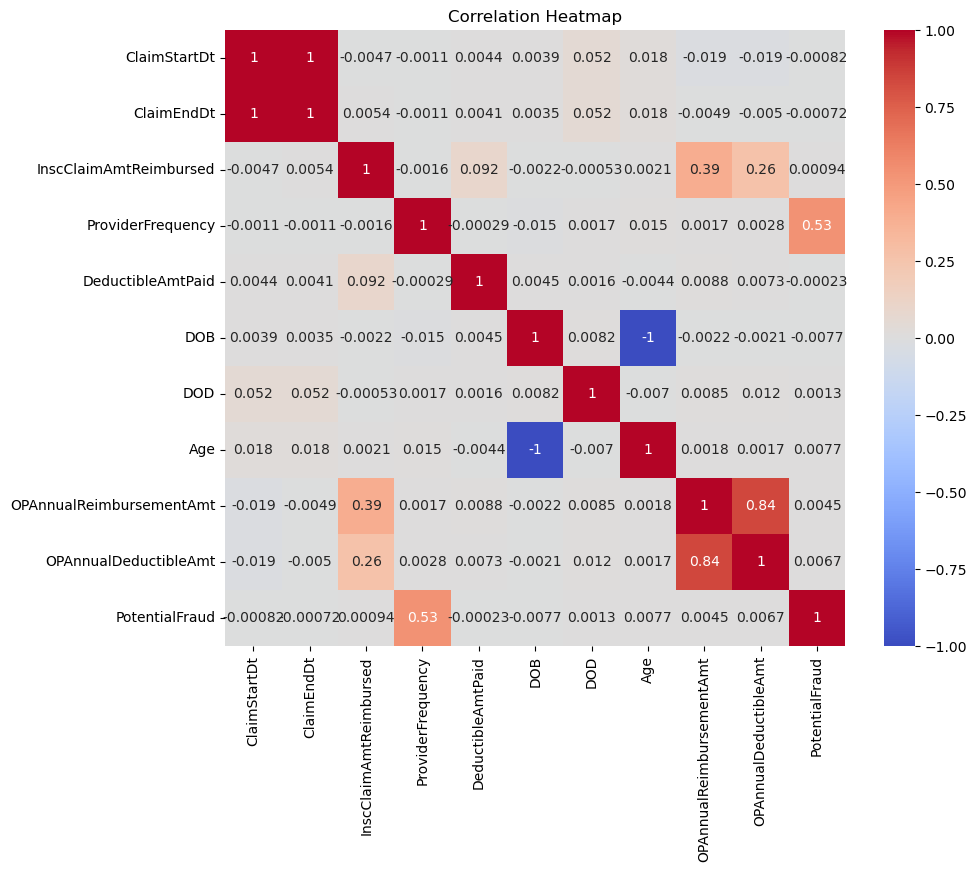

The figure layout has changed to tight


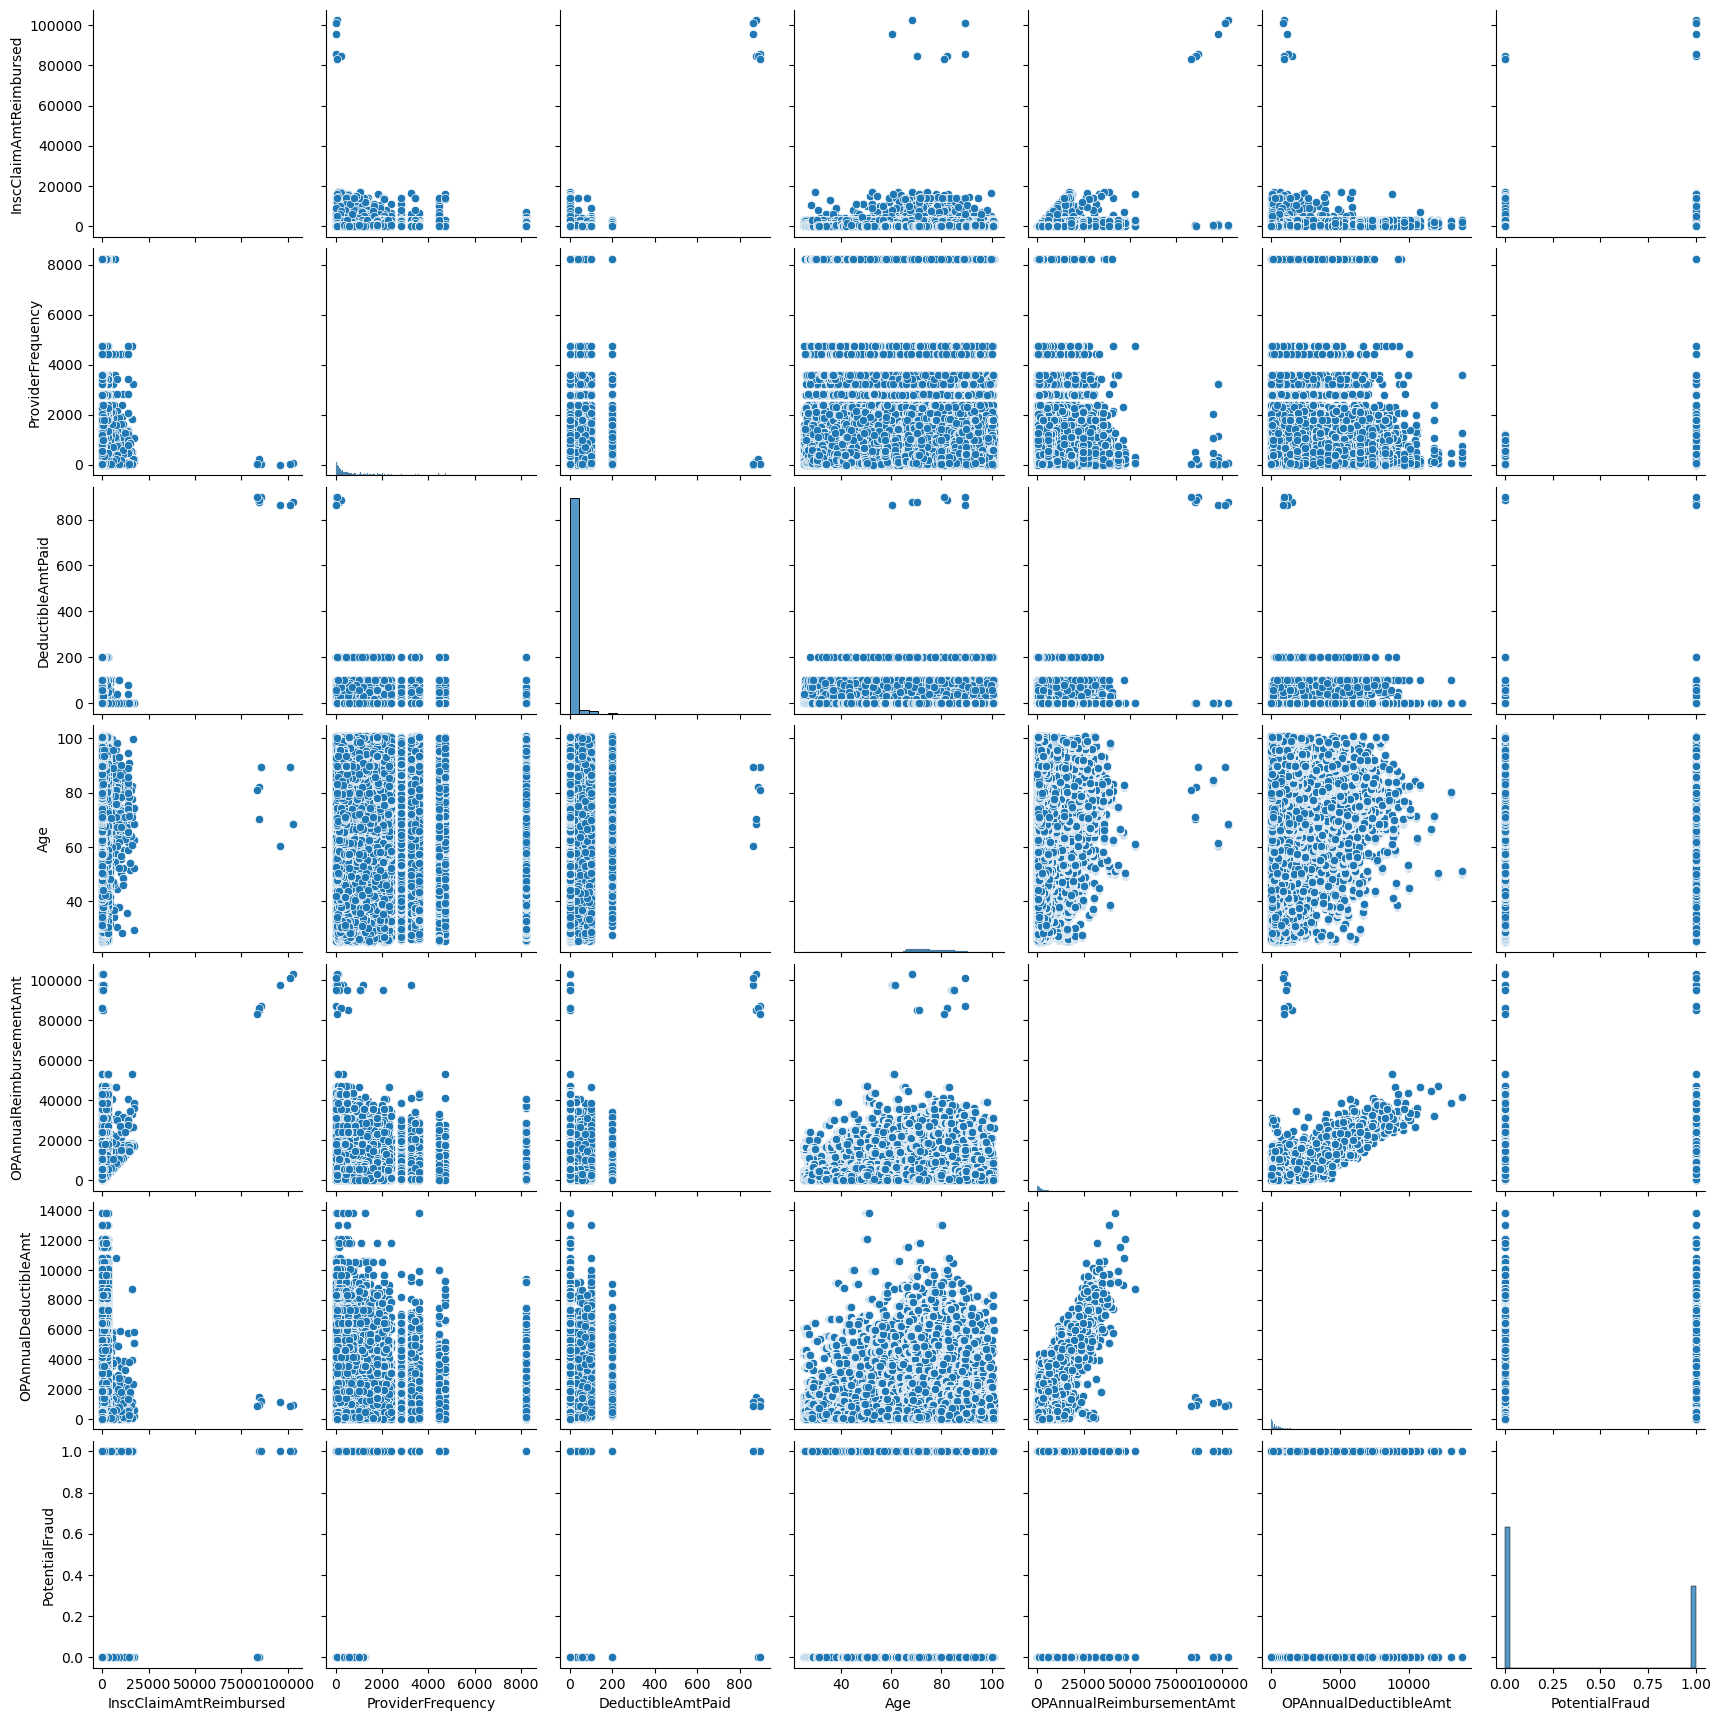

The feature ProviderFrequency exhibits a moderately strong positive linear relationship with the target and the InscClaimAmtReimbursed displays a non-linear correlation with the target. The remaining features appear to have little to no correlation. In an effort to enhance the model's performance, I have opted to incorporate these two numerical features into the training process.


In [51]:
# visualize the confusion matrix and scatter plots
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(numerical_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

sns.pairplot(numerical_df)
plt.show()

# Observation:
print("The feature ProviderFrequency exhibits a moderately strong positive linear relationship with the target and the InscClaimAmtReimbursed displays a non-linear correlation with the target. The remaining features appear to have little to no correlation. In an effort to enhance the model's performance, I have opted to incorporate these two numerical features into the training process.")

## 4. Model training and Selection

##### (1). Construction of functions for pipelines

In [52]:
# Create a Transformer
class Transformer:
    def __init__(self, df2, df3):
        self.df =None
        self.df2 = df2[["BeneID","Race","State"]]
        self.df3 = df3
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = pd.DataFrame()
        
        df["ClaimID"] = X["ClaimID"]
        df["BeneID"] = X["BeneID"]
        df["Provider"] = X["Provider"]
        
        df["InscClaimAmtReimbursed"] = X["InscClaimAmtReimbursed"]
        
        df["PrincipalDiagnosticCategory"] = X["ClmDiagnosisCode_1"].apply(self.CDC_to_TDC)
        
        df = pd.merge(df,self.df2, how='left', on='BeneID')
        df = pd.merge(df,self.df3, how='left', on='Provider')
        
        ProviderFrequency = X.groupby(["Provider"]).count()["ClaimID"].reset_index(name = "ProviderFrequency")
        df = pd.merge(df,ProviderFrequency,on="Provider",how="left")
        
        df = df.drop(["ClaimID", "BeneID","Provider","PotentialFraud"], axis=1)
        
        self.df = df
        
        return df

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
    
    def CDC_to_TDC(self,value):
        if pd.isnull(value):return "0"

        # purely numeric
        if value[0] not in ("V","E"):
            # get the first three digit of Claim Diagnosis Code
            first_three_digit = int(value[:3])
            if 1<= first_three_digit <= 9: return "1"
            if 10<= first_three_digit <= 18: return "2"
            if 20<= first_three_digit <= 27: return "3"
            if 30<= first_three_digit <= 41: return "4"
            if 42<= first_three_digit <= 42: return "5"
            if 45<= first_three_digit <= 49: return "6"
            if 50<= first_three_digit <= 59: return "7"
            if 60<= first_three_digit <= 66: return "8"
            if 70<= first_three_digit <= 79: return "9"
            if 80<= first_three_digit <= 88: return "10"
            if 90<= first_three_digit <= 99: return "11"
            if 100<= first_three_digit <= 104: return "12"
            if 110<= first_three_digit <= 118: return "13"
            if 120<= first_three_digit <= 129: return "14"
            if 130<= first_three_digit <= 136: return "15"
            if 137<= first_three_digit <= 139: return "16"
            if 140<= first_three_digit <= 149: return "17"
            if 150<= first_three_digit <= 159: return "18"
            if 160<= first_three_digit <= 165: return "19"
            if 170<= first_three_digit <= 176: return "20"
            if 179<= first_three_digit <= 189: return "21"
            if 190<= first_three_digit <= 199: return "22"
            if 200<= first_three_digit <= 208: return "23"
            if 209<= first_three_digit <= 209: return "24"
            if 210<= first_three_digit <= 229: return "25"
            if 230<= first_three_digit <= 234: return "26"
            if 235<= first_three_digit <= 238: return "27"
            if 239<= first_three_digit <= 239: return "28"
            if 240<= first_three_digit <= 246: return "29"
            if 249<= first_three_digit <= 259: return "30"
            if 260<= first_three_digit <= 269: return "31"
            if 270<= first_three_digit <= 279: return "32"
            if 280<= first_three_digit <= 289: return "33"
            if 290<= first_three_digit <= 294: return "34"
            if 295<= first_three_digit <= 299: return "35"
            if 300<= first_three_digit <= 316: return "36"
            if 317<= first_three_digit <= 319: return "37"
            if 320<= first_three_digit <= 327: return "38"
            if 330<= first_three_digit <= 337: return "39"
            if 338<= first_three_digit <= 338: return "40"
            if 339<= first_three_digit <= 339: return "41"
            if 340<= first_three_digit <= 349: return "42"
            if 350<= first_three_digit <= 359: return "43"
            if 360<= first_three_digit <= 379: return "44"
            if 380<= first_three_digit <= 389: return "45"
            if 390<= first_three_digit <= 392: return "46"
            if 393<= first_three_digit <= 398: return "47"
            if 401<= first_three_digit <= 405: return "48"
            if 410<= first_three_digit <= 414: return "49"
            if 415<= first_three_digit <= 417: return "50"
            if 420<= first_three_digit <= 429: return "51"
            if 430<= first_three_digit <= 438: return "52"
            if 440<= first_three_digit <= 449: return "53"
            if 451<= first_three_digit <= 459: return "54"
            if 460<= first_three_digit <= 466: return "55"
            if 470<= first_three_digit <= 478: return "56"
            if 480<= first_three_digit <= 488: return "57"
            if 490<= first_three_digit <= 496: return "58"
            if 500<= first_three_digit <= 508: return "59"
            if 510<= first_three_digit <= 519: return "60"
            if 520<= first_three_digit <= 529: return "61"
            if 530<= first_three_digit <= 539: return "62"
            if 540<= first_three_digit <= 543: return "63"
            if 550<= first_three_digit <= 553: return "64"
            if 555<= first_three_digit <= 558: return "65"
            if 560<= first_three_digit <= 569: return "66"
            if 570<= first_three_digit <= 579: return "67"
            if 580<= first_three_digit <= 589: return "68"
            if 590<= first_three_digit <= 599: return "69"
            if 600<= first_three_digit <= 608: return "70"
            if 610<= first_three_digit <= 611: return "71"
            if 614<= first_three_digit <= 616: return "72"
            if 617<= first_three_digit <= 629: return "73"
            if 630<= first_three_digit <= 639: return "74"
            if 640<= first_three_digit <= 649: return "75"
            if 650<= first_three_digit <= 659: return "76"
            if 660<= first_three_digit <= 669: return "77"
            if 670<= first_three_digit <= 677: return "78"
            if 678<= first_three_digit <= 679: return "79"
            if 680<= first_three_digit <= 686: return "80"
            if 690<= first_three_digit <= 698: return "81"
            if 700<= first_three_digit <= 709: return "82"
            if 710<= first_three_digit <= 719: return "83"
            if 720<= first_three_digit <= 724: return "84"
            if 725<= first_three_digit <= 729: return "85"
            if 730<= first_three_digit <= 739: return "86"
            if 740<= first_three_digit <= 759: return "87"
            if 760<= first_three_digit <= 763: return "88"
            if 764<= first_three_digit <= 779: return "89"
            if 780<= first_three_digit <= 789: return "90"
            if 790<= first_three_digit <= 796: return "91"
            if 797<= first_three_digit <= 799: return "92"
            if 800<= first_three_digit <= 804: return "93"
            if 805<= first_three_digit <= 809: return "94"
            if 810<= first_three_digit <= 819: return "95"
            if 820<= first_three_digit <= 829: return "96"
            if 830<= first_three_digit <= 839: return "97"
            if 840<= first_three_digit <= 848: return "98"
            if 850<= first_three_digit <= 854: return "99"
            if 860<= first_three_digit <= 869: return "100"
            if 870<= first_three_digit <= 879: return "101"
            if 880<= first_three_digit <= 887: return "102"
            if 890<= first_three_digit <= 897: return "103"
            if 900<= first_three_digit <= 904: return "104"
            if 905<= first_three_digit <= 909: return "105"
            if 910<= first_three_digit <= 919: return "106"
            if 920<= first_three_digit <= 924: return "107"
            if 925<= first_three_digit <= 929: return "108"
            if 930<= first_three_digit <= 939: return "109"
            if 940<= first_three_digit <= 949: return "110"
            if 950<= first_three_digit <= 957: return "111"
            if 958<= first_three_digit <= 959: return "112"
            if 960<= first_three_digit <= 979: return "113"
            if 980<= first_three_digit <= 989: return "114"
            if 990<= first_three_digit <= 995: return "115"
            if 996<= first_three_digit <= 999: return "116"

        # code beginning with E  
        elif value[0] == "E":
            # get the first three digit of Claim Diagnosis Code
            first_three_digit = int(value[1:4])
            if 0<= first_three_digit <= 0: return "133"
            if 1<= first_three_digit <= 30: return "134"
            if 800<= first_three_digit <= 807: return "135"
            if 810<= first_three_digit <= 819: return "136"
            if 820<= first_three_digit <= 825: return "137"
            if 826<= first_three_digit <= 829: return "138"
            if 830<= first_three_digit <= 838: return "139"
            if 840<= first_three_digit <= 845: return "140"
            if 846<= first_three_digit <= 849: return "141"
            if 850<= first_three_digit <= 858: return "142"
            if 860<= first_three_digit <= 869: return "143"
            if 870<= first_three_digit <= 876: return "144"
            if 878<= first_three_digit <= 879: return "145"
            if 880<= first_three_digit <= 888: return "146"
            if 890<= first_three_digit <= 899: return "147"
            if 900<= first_three_digit <= 909: return "148"
            if 910<= first_three_digit <= 915: return "149"
            if 916<= first_three_digit <= 928: return "150"
            if 929<= first_three_digit <= 929: return "151"
            if 930<= first_three_digit <= 949: return "152"
            if 950<= first_three_digit <= 959: return "153"
            if 960<= first_three_digit <= 969: return "154"
            if 970<= first_three_digit <= 978: return "155"
            if 980<= first_three_digit <= 989: return "156"
            if 990<= first_three_digit <= 999: return "157"

        # code beginning with V
        elif value[0] == "V":
            # get the first two digit of Claim Diagnosis Code
            first_two_digit = int(value[1:3])
            if 1 <= first_two_digit <= 9: return "117"
            if 10 <= first_two_digit <= 19: return "118"
            if 20 <= first_two_digit <= 29: return "119"
            if 30 <= first_two_digit <= 39: return "120"
            if 40 <= first_two_digit <= 49: return "121"
            if 50 <= first_two_digit <= 59: return "122"
            if 60 <= first_two_digit <= 69: return "123"
            if 70 <= first_two_digit <= 82: return "124"
            if 83 <= first_two_digit <= 84: return "125"
            if 85 <= first_two_digit <= 85: return "126"
            if 86 <= first_two_digit <= 86: return "127"
            if 87 <= first_two_digit <= 87: return "128"
            if 88 <= first_two_digit <= 88: return "129"
            if 89 <= first_two_digit <= 89: return "130"
            if 90 <= first_two_digit <= 90: return "131"
            if 91 <= first_two_digit <= 91: return "132"
        
        return "999"
    
    def get_feature_names_out(self, input_features=None):
        # Generate the list of output feature names
        output_feature_names = self.df.columns
        return output_feature_names

In [53]:
# load the original data
df_label = pd.read_csv(".\kaggle_data\Train-1542865627584.csv")
df_bene = pd.read_csv(".\kaggle_data\Train_Beneficiarydata-1542865627584.csv")
df_outp = pd.read_csv(".\kaggle_data\Train_Outpatientdata-1542865627584.csv")

transformer = Transformer(df_bene, df_label)
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

##### (2). Creation of training and testing sets.

In [54]:
# Define key features for model training after EDA
numerical_features = ['ProviderFrequency','InscClaimAmtReimbursed']
categorical_features = ['PrincipalDiagnosticCategory',  'Race',  'State']
key="Provider"
target = "PotentialFraud"

# Create a function to derive training and testing sets
def create_training_testing_set(df_primary,df_label,key,target,test_size,random_state):
    df_label[target] = df_label[target].apply(lambda x:1 if x=="Yes" or x==1 else 0)
    
    X_train, X_test, y_train, y_test = train_test_split(df_label, df_label,test_size=test_size,random_state=random_state)
    
    df_train_merge = pd.merge(df_primary, X_train, on = key , how ="inner")
    df_test_merge = pd.merge(df_primary, X_test, on = key , how ="inner")
    
    X_train = df_train_merge
    y_train = df_train_merge[target]
    
    X_test = df_test_merge
    y_test = df_test_merge[target]

    return X_train, X_test, y_train, y_test

# create the training and testing set
X_train, X_test, y_train, y_test = create_training_testing_set(df_outp,df_label,key,target,0.2,66)

##### (3). Model Training and Fine-tuning

In [55]:
# Calculate weight
weight = negative_cases / positive_cases

# fine-tune the model
xgb_pipe = Pipeline(
            steps=[
            ('custom_transform', transformer),
            ('preprocessor', ColumnTransformer(transformers = [('categorical', one_hot_encoder, categorical_features)],
                                               remainder = 'passthrough')),
            ('xgb', XGBClassifier())])

param = {
        'xgb__n_estimators': [50, 100,200],  # 
        'xgb__learning_rate': [0.4,0.5,0.6],  
        'xgb__reg_alpha': [200,300, 500],
        'xgb__reg_lambda': [50, 100,200] ,    
        'xgb__max_depth': [5,10],
        'xgb__scale_pos_weight':[weight]
        }
    
cv = KFold(n_splits=3, shuffle=True, random_state=66)

xgb_cv1 = GridSearchCV(xgb_pipe, param_grid=param, cv=cv, scoring="f1")
xgb_cv1.fit(X_train,y_train)

print("Best parameter for XGBoost:", xgb_cv1.best_params_)

rf_pipe = Pipeline(
            steps=[
            ('custom_transform', transformer),
            ('preprocessor', ColumnTransformer(transformers = [('categorical', one_hot_encoder, categorical_features)],
                                               remainder = 'passthrough')),
            ('rf', RandomForestClassifier())])

param = {
        'rf__n_estimators': [50, 100,200],     
        'rf__max_depth': [30, 50, 100 ],  
        'rf__max_features': [ 3, 5, 10],
        'rf__min_samples_leaf': [5, 10, 20],
        'rf__class_weight':["balanced"]
        }
    
rf_cv1 = GridSearchCV(rf_pipe, param_grid=param, cv=cv, scoring="f1")
rf_cv1.fit(X_train,y_train)

print("Best parameter for Random Forest:", rf_cv1.best_params_)

Best parameter for XGBoost: {'xgb__learning_rate': 0.4, 'xgb__max_depth': 5, 'xgb__n_estimators': 50, 'xgb__reg_alpha': 500, 'xgb__reg_lambda': 200, 'xgb__scale_pos_weight': 1.7336504852318446}
Best parameter for Random Forest: {'rf__class_weight': 'balanced', 'rf__max_depth': 50, 'rf__max_features': 5, 'rf__min_samples_leaf': 20, 'rf__n_estimators': 50}


In [75]:
# train the XGBoost model with optimal hyperparmaters
xgb_pipe = Pipeline(
            steps=[
            ('custom_transform', transformer),
            ('preprocessor', ColumnTransformer(transformers = [('categorical', one_hot_encoder, categorical_features)],
                                               remainder = 'passthrough')),
            ('xgb', XGBClassifier(learning_rate = xgb_cv1.best_params_['xgb__learning_rate'],
                                  max_depth = xgb_cv1.best_params_['xgb__max_depth'],
                                  n_estimators = xgb_cv1.best_params_['xgb__n_estimators'],
                                  reg_alpha = xgb_cv1.best_params_['xgb__reg_alpha'],
                                  reg_lambda = xgb_cv1.best_params_['xgb__reg_lambda'],
                                  scale_pos_weight = weight
                                 ))]
                           )

# Fit the pipeline to your training data and count the running time
start  = time.time()
xgb_model = xgb_pipe.fit(X_train, y_train)
end = time.time()
xgb_runing_time = end - start


# train the Random Forest model with optimal hyperparmaters
rf_pipe = Pipeline(
            steps=[
            ('custom_transform', transformer),
            ('preprocessor', ColumnTransformer(transformers = [('categorical', one_hot_encoder, categorical_features)],
                                               remainder = 'passthrough')),
            ('rf', RandomForestClassifier(n_estimators = rf_cv1.best_params_['rf__n_estimators'],
                                          max_depth = rf_cv1.best_params_['rf__max_depth'],
                                          min_samples_leaf = rf_cv1.best_params_['rf__min_samples_leaf'],
                                          max_features = rf_cv1.best_params_['rf__max_features'],
                                          class_weight = 'balanced'
                                            ))]
                           )

# Fit the pipeline to your training data
start  = time.time()
rf_model = rf_pipe.fit(X_train, y_train)
end = time.time()
rf_runing_time = end - start

##### (4). Performance Analysis and Model Selection

Running time of XGBoost Model: 5.008479595184326
Report_train: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    257308
           1       0.95      0.88      0.92    160593

    accuracy                           0.94    417901
   macro avg       0.94      0.93      0.93    417901
weighted avg       0.94      0.94      0.94    417901

Report_test: 
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     71035
           1       0.66      0.65      0.66     28801

    accuracy                           0.80     99836
   macro avg       0.76      0.76      0.76     99836
weighted avg       0.80      0.80      0.80     99836



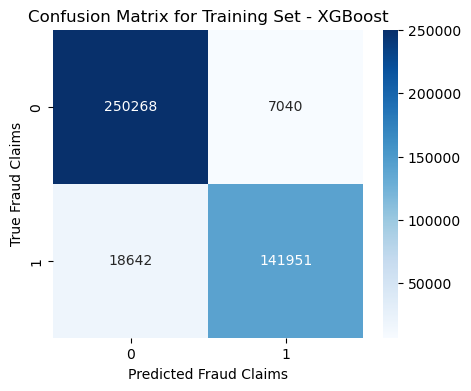

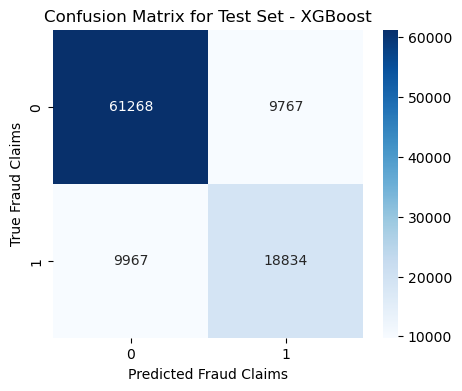

In [76]:
# derive the predicted outcomes
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# output the performance metrics
report_train_xgb = classification_report(y_train, y_train_pred_xgb)
report_test_xgb = classification_report(y_test, y_test_pred_xgb)

print("Running time of XGBoost Model:",xgb_runing_time)
print("Report_train: ")
print(report_train_xgb)
print("Report_test: ")
print(report_test_xgb)

cm_train_xgb = confusion_matrix(y_train, y_train_pred_xgb)
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb)

# For the training set
plt.figure(figsize=(5, 4))
sns.heatmap(cm_train_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Training Set - XGBoost')
plt.xlabel('Predicted Fraud Claims')
plt.ylabel('True Fraud Claims')
plt.show()

# For the test set
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Test Set - XGBoost')
plt.xlabel('Predicted Fraud Claims')
plt.ylabel('True Fraud Claims')
plt.show()

Running time of Random Forest Model: 25.222171783447266
Report_train: 
              precision    recall  f1-score   support

           0       0.84      0.92      0.88    257308
           1       0.85      0.71      0.78    160593

    accuracy                           0.84    417901
   macro avg       0.85      0.82      0.83    417901
weighted avg       0.84      0.84      0.84    417901

Report_test: 
              precision    recall  f1-score   support

           0       0.82      0.85      0.84     71035
           1       0.60      0.54      0.57     28801

    accuracy                           0.76     99836
   macro avg       0.71      0.70      0.70     99836
weighted avg       0.76      0.76      0.76     99836



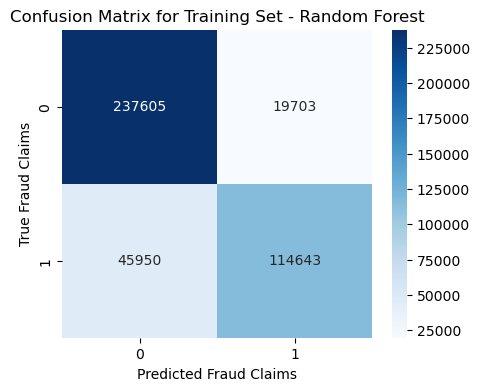

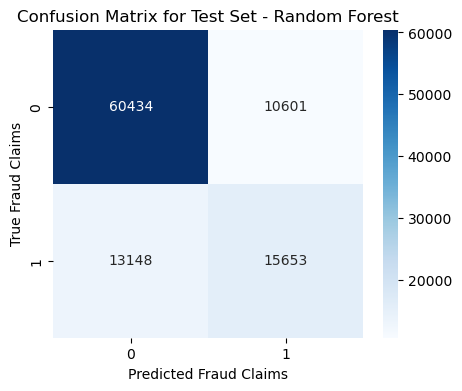

In [78]:
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

report_train_rf = classification_report(y_train, y_train_pred_rf)
report_test_rf = classification_report(y_test, y_test_pred_rf)

print("Running time of Random Forest Model:",rf_runing_time)
print("Report_train: ")
print(report_train_rf)
print("Report_test: ")
print(report_test_rf)

cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
cm_test_rf = confusion_matrix(y_test, y_test_pred_rf)

# For the training set
plt.figure(figsize=(5, 4))
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Training Set - Random Forest')
plt.xlabel('Predicted Fraud Claims')
plt.ylabel('True Fraud Claims')
plt.show()

# For the test set
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Test Set - Random Forest')
plt.xlabel('Predicted Fraud Claims')
plt.ylabel('True Fraud Claims')
plt.show()

In [79]:
# choose the final model
final_model = xgb_model["xgb"]
print("I would like to choose XGBoost model since it has better efficiency and performance.")

I would like to choose XGBoost model since it has better efficiency and performance.


## 5. Model Interpretation

[00:23:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


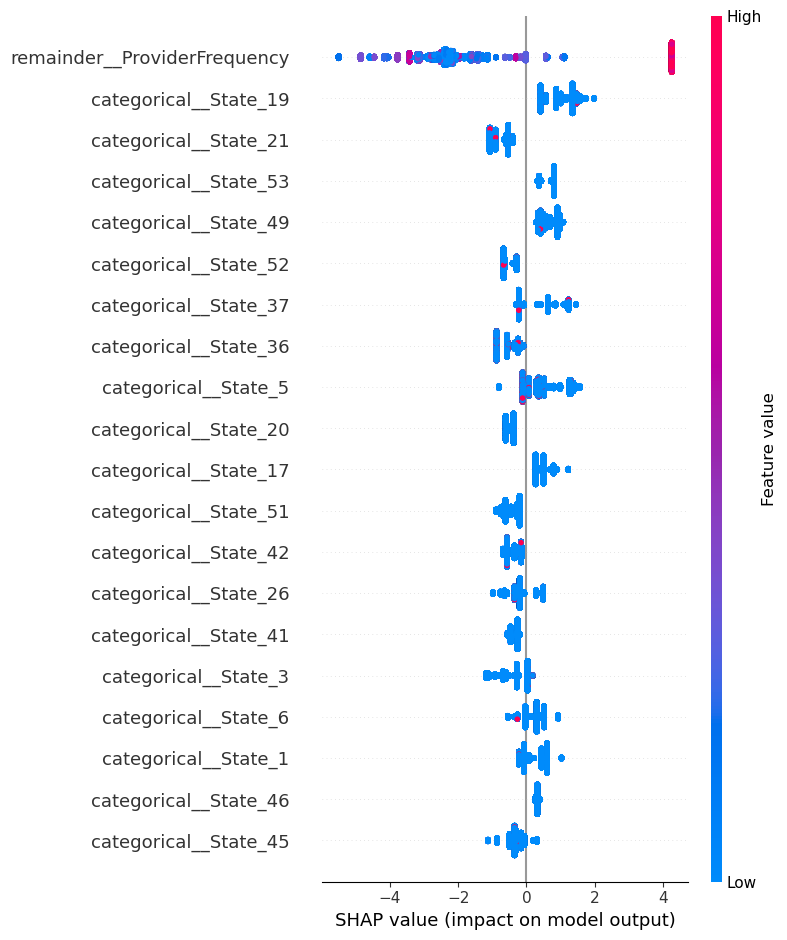

The most impactful features are ProviderFrequency and State.
Examine the attributes of Provider and State in the claims record carefully.


In [84]:
# Extract the model and preprocessing part of the pipeline
preprocess_pipeline = Pipeline(xgb_pipe.steps[:-1])

# Transform the test data
X_test_transform = preprocess_pipeline.transform(X_test)
X_test_transform = X_test_transform.toarray()

# Calculate SHAP values
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_transform)

# Output the final feature names from the transformer
transformed_feature_names = list(preprocess_pipeline.get_feature_names_out())

# Summarize the effects of features
shap.summary_plot(shap_values, X_test_transform, feature_names=transformed_feature_names)

# Observation:
print("The most impactful features are ProviderFrequency and State.")

# Actionable suggestions:
print("Examine the attributes of Provider and State in the claims record carefully.")

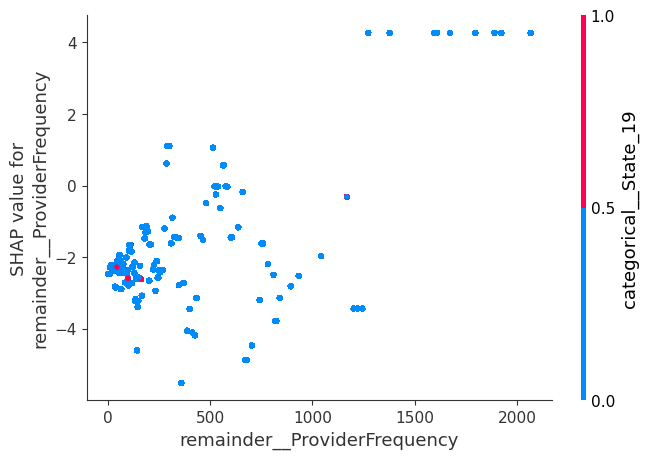

When the ProviderFrequency exceeds 1300, it begins to positively affect the detection of fraud claims. However, this applies to only a limited number of claims, which explains the lower recall rate in outpatient data compared to inpatient data. In inpatient data, the ProviderFrequency over 60 can positively influence a larger set of claims, enhancing fraud detection capabilities.
Focus increased scrutiny on claims from Providers with over 1300 claim records in a single year, while also considering the impact of the State in the evaluation process.


In [85]:
# Find the index of the relevant features
feature_index = transformed_feature_names.index('remainder__ProviderFrequency')
interaction_index = transformed_feature_names.index('categorical__State_19')

# Use the index for the SHAP dependence plot
shap.dependence_plot(feature_index, shap_values, X_test_transform, interaction_index=interaction_index, feature_names=transformed_feature_names)

# Observation:
print("When the ProviderFrequency exceeds 1300, it begins to positively affect the detection of fraud claims. However, this applies to only a limited number of claims, which explains the lower recall rate in outpatient data compared to inpatient data. In inpatient data, the ProviderFrequency over 60 can positively influence a larger set of claims, enhancing fraud detection capabilities.")

# Actionable suggestions:
print("Focus increased scrutiny on claims from Providers with over 1300 claim records in a single year, while also considering the impact of the State in the evaluation process.")

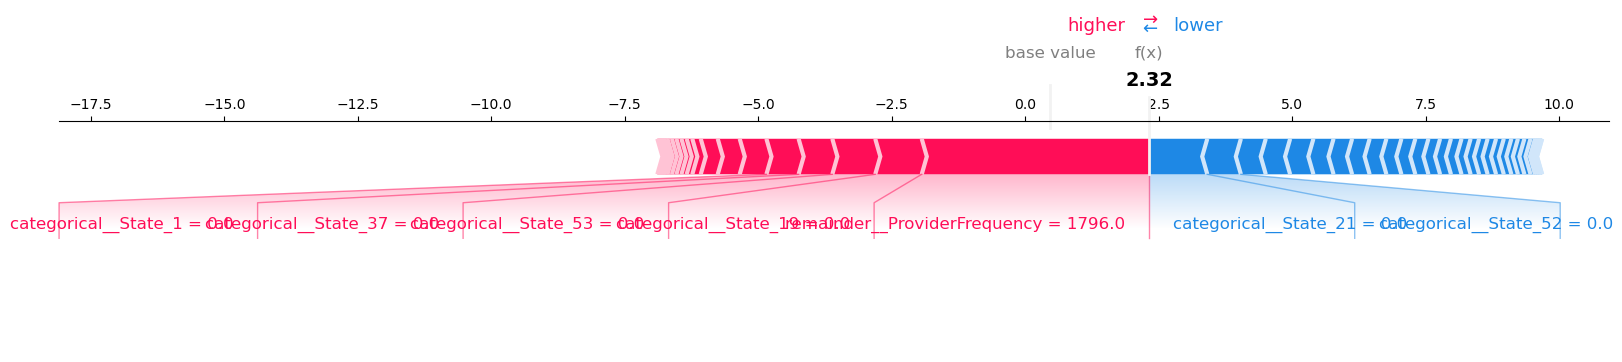

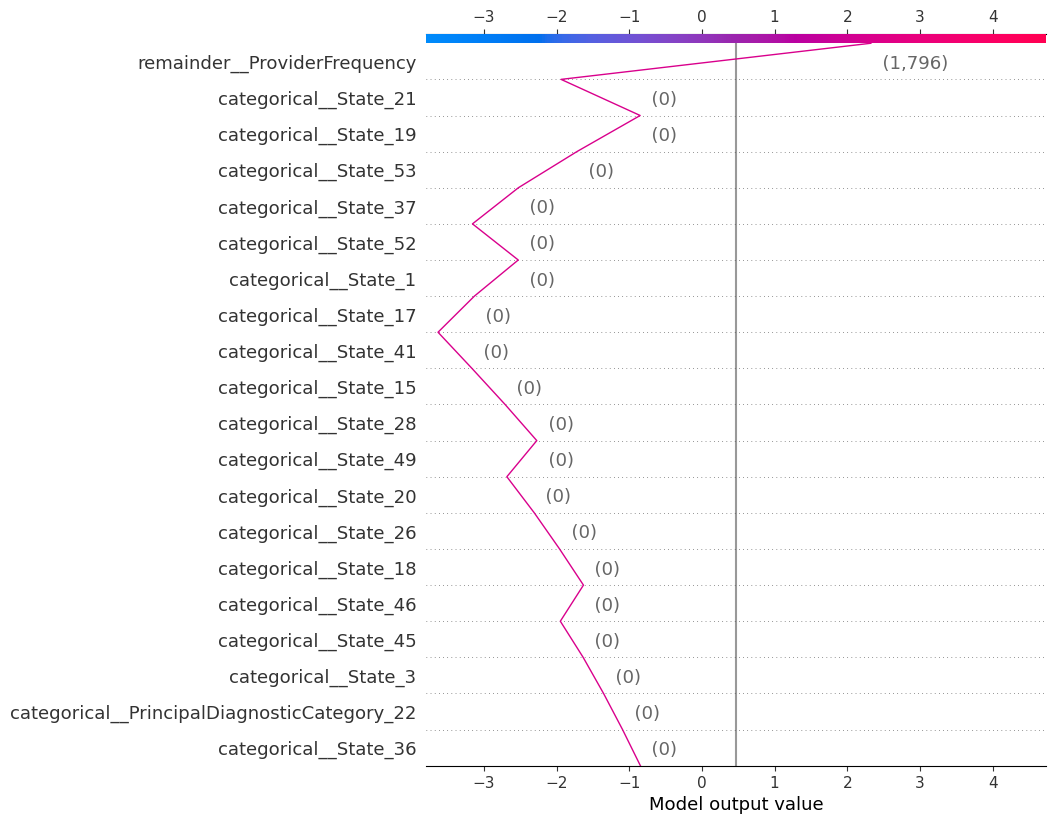

For the instance at index 5000, which is a positive classification, the ProviderFrequency predominantly influences the model's decision.


In [86]:
# Case study - positive case
# Use the index for the force plot
index = 5000
shap.plots.force(explainer.expected_value, shap_values[index], X_test_transform[index], feature_names=transformed_feature_names, matplotlib = True)

# Use the index for the decision plot
shap.decision_plot(explainer.expected_value, shap_values[index], X_test_transform[index], feature_names=transformed_feature_names)

# Observation:
print("For the instance at index 5000, which is a positive classification, the ProviderFrequency predominantly influences the model's decision.")

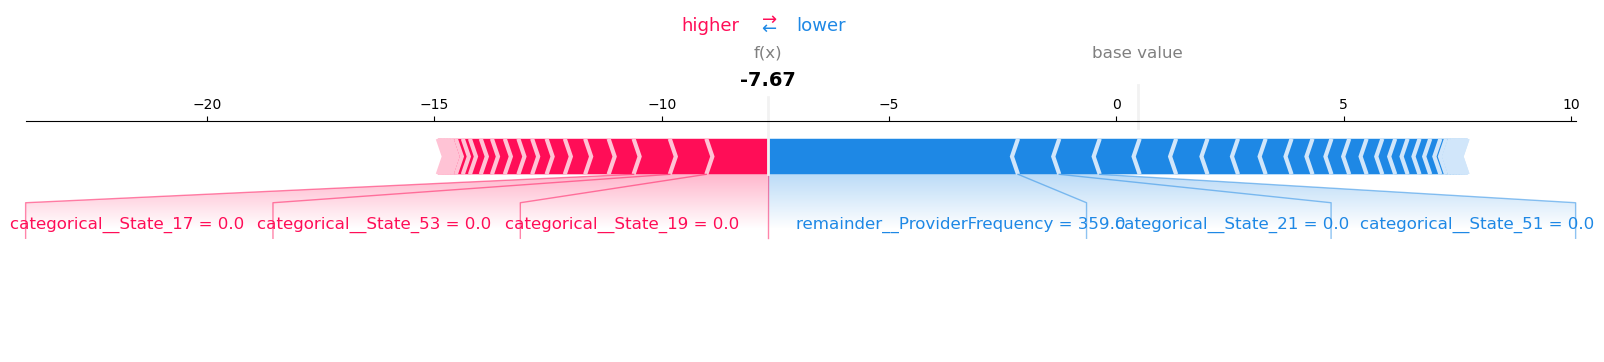

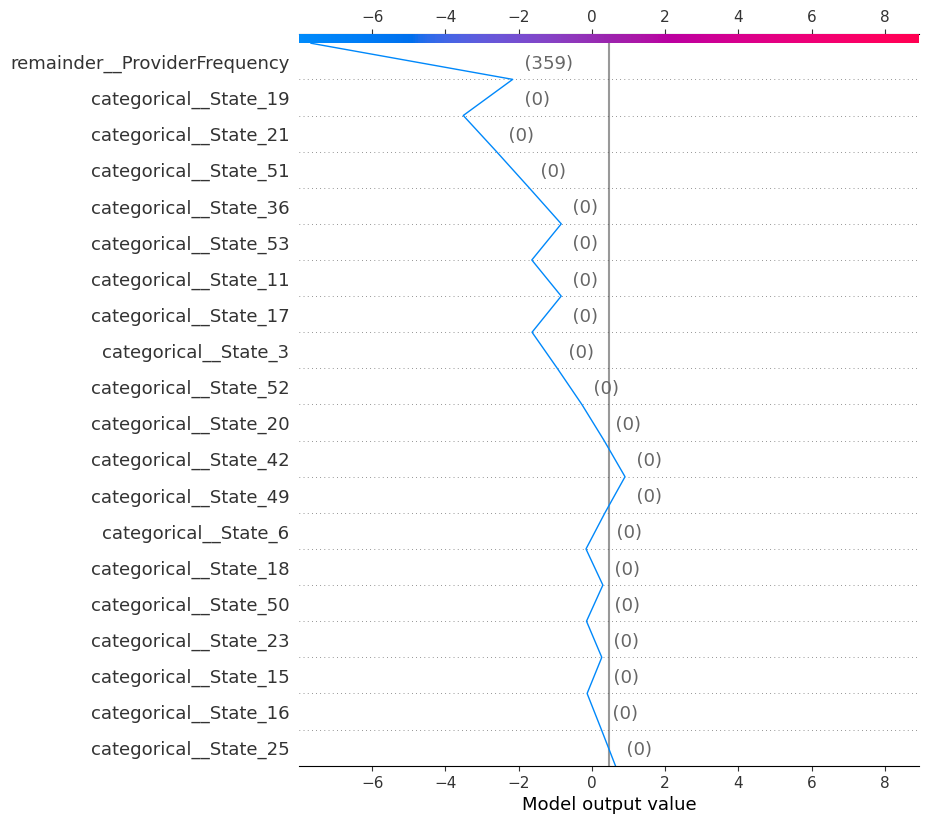

For the instance at index 0, which is a negative classification, the ProviderFrequency is the primary influencer on the model's decision. Additionally, the decision is also affected by features of the PrincipalDiagnosticCategory and State.


In [87]:
# Case study - negative case
# Use the index for the force plot
index = 0
shap.plots.force(explainer.expected_value, shap_values[index], X_test_transform[index], feature_names=transformed_feature_names, matplotlib = True)

# Use the index for the decision plot
shap.decision_plot(explainer.expected_value, shap_values[index], X_test_transform[index], feature_names=transformed_feature_names)

# Observation:
print("For the instance at index 0, which is a negative classification, the ProviderFrequency is the primary influencer on the model's decision. Additionally, the decision is also affected by features of the PrincipalDiagnosticCategory and State.")